In [31]:
#Required Libraries
import pandas as pd
import random
import warnings
import json
from pathlib import Path
from scipy.spatial.distance import euclidean
import numpy as np
from fastdtw import fastdtw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy
import statistics

#!conda install -c bioconda fastdtw

# Methods
def read_json_data(path: str) -> {}:
    """
    reads the JSON data and stores it as a dictionary
    :param path: the path of the corresponding file
    :return: a dictionary containing the json data of the file
    """
    with open(path) as data_file:
        data = json.load(data_file)
    return data

def get_trajectory_by_id(trajectories: [{}], trajectory_id: int):
    """
    :param trajectories: the list of collected trajectories
    :param trajectory_id: unique id of the trajectory to return
    :return: the associated trajectory with the id
    """
    for trajectory in trajectories:
        if trajectory['id'] == trajectory_id:
            return trajectory
    return None

def get_filename_list_from_directory(directory_name: str) -> []:
    """
    :param directory_name:
    :return: a list containing all the path file names stored in the given directory
    """
    pathlist = Path(directory_name).glob('**/*.json')
    return pathlist

def get_touch_points_with_figures(directory: str)->[{}]:
    '''
    returns the raw data list of dictionaries corresponding to Game Records from the directory.
    :param directory:
    :return: A list of dictionaries with the raw data
    '''
    
    json_filename_list = get_filename_list_from_directory(directory)
    
    raw_data = [read_json_data(game_data) for game_data in json_filename_list]
    points = {}
    matched_points = []
    unmatched_points = []
    trajectory_counter = 0
    figure_groups = []
    for game in raw_data:
        for match in game['touchDataList']['matched']:
            temp_figures = []
            for figure in match['sameFigures']:
                temp_figures.append([figure['x'], figure['y']])
            counter = 0
            for figure_group in figure_groups:
                if len(figure_group) == len(temp_figures):
                    if counter != len(figure_group):
                        for temp_figure in temp_figures:
                            if temp_figure in figure_group:
                                counter +=1
                    if counter != len(temp_figures):
                        counter = 0
                    if counter == len(temp_figures):
                        temp_figures = figure_group
            if counter == 0:
                figure_groups.append(temp_figures)
            trajectory_counter += 1
            trajectory_group = figure_groups.index(temp_figures)
            for point in match['points']:
                point['uid1'] = game['userData']['uid1']
                point['uid2'] = game['userData']['uid2']
                point['deltaTimeTrajectory'] = point['deltaTime'] - match['points'][0]['deltaTime']
                point['trajectory_id'] = trajectory_counter
                point['trajectory_group'] = trajectory_group
                #for i in range(0,len(temp_figures)):
                #    key_name = 'figure'+str(i+1)
                #    point[key_name] = temp_figures[i]
                if point['uid1'] != 'unbekannt':
                    matched_points.append(point)
        for unmatch in game['touchDataList']['unmatched']:
            for point in match['points']:
                unmatched_points.append(point)
    points['matched'] = matched_points
    points['unmatched'] = unmatched_points
    return points 

def get_all_trajectories(directory: str) -> [{}]:
    """
    :param directory: the directory name where the json files are located
    :return:a list of trajectory dictionaries
    a list of all trajectories represented as dictionaries with the following values as keys:

    figures: List of paired figures in the trajectory. Each figure contains the positions in the x and y coordinates.
    group: Each path is grouped according to the positions of the paired figures.
    time: List with the time series represented in seconds for each of the points that make up the trajectory.
    x: List with the positions of the points on the horizontal axis of the screen
    y: List with the positions of the points on the vertical axis of the screen
    uid1: the assigned unique number by which player 1 of the same game round is referred to
    uid2: the assigned unique number by which player 2 of the same game round is referred to
    """
    json_filename_list = get_filename_list_from_directory(directory)
    raw_data = [read_json_data(game_data) for game_data in json_filename_list]
    trajectories = []
    trajectory_counter = 0
    figure_groups = []
    numeric_uids = {}
    current_uid_index = 0
    for game in raw_data:
        if game['userData']['uid1'] != 'unbekannt': # Remove this if you also want to include unknown uid1 users
            for match in game['touchDataList']['matched']:
                temp_figures = []
                for figure in match['sameFigures']:
                    temp_figures.append([figure['x'], figure['y']])
                counter = 0
                figures_already_in_figure_group = False
                for figure_group in figure_groups:
                    if len(temp_figures) == len(figure_group):
                        if counter < len(temp_figures):
                            for figure in temp_figures:
                                if figure in figure_group:
                                    counter = counter + 1
                        if counter < len(temp_figures):
                            counter = 0
                        if counter == len(temp_figures) and figures_already_in_figure_group == False:
                            temp_figures = figure_group
                            figures_already_in_figure_group = True
                if counter < len(temp_figures):
                    figure_groups.append(temp_figures)
                trajectory_counter += 1
                trajectory_group = figure_groups.index(temp_figures)
                temp_trajectory = {}
                if game['userData']['uid1'] not in numeric_uids.keys():
                    numeric_uids[game['userData']['uid1']] = current_uid_index
                    current_uid_index += 1
                if game['userData']['uid2'] != "":
                    if game['userData']['uid2'] not in numeric_uids.keys():
                        numeric_uids[game['userData']['uid2']] = current_uid_index
                        current_uid_index += 1
                temp_trajectory['uid1'] = numeric_uids[game['userData']['uid1']]
                if game['userData']['uid2'] != "":
                    temp_trajectory['uid2'] = numeric_uids[game['userData']['uid2']]
                else:
                    temp_trajectory['uid2'] = ""
                temp_trajectory['id'] = trajectory_counter
                temp_trajectory['uid1String'] = game['userData']['uid1']
                temp_trajectory['uid2String'] = game['userData']['uid2']
                temp_trajectory['group'] = trajectory_group
                temp_trajectory['time'] = [i['deltaTime'] - match['points'][0]['deltaTime'] for i in match['points']]
                temp_trajectory['x'] = [i['x'] for i in match['points']]
                temp_trajectory['y'] = [i['y'] for i in match['points']]
                temp_trajectory['figures'] = temp_figures
                trajectories.append(temp_trajectory)
        sorted(trajectories, key=lambda i: i['group'])
    return trajectories

def get_trajectory_groups(trajectories: {}):
    from operator import itemgetter

    """
    :param trajectories: the list of trajectories
    :return: a list of trajectory_group dictionaries with the group number of trajectories as a key and the users that are part
    of such a group as values, In addition to this the 'trajectories' key shows the number of trajectories 
    that conform this group.
    """
    trajectory_groups = {}
    for trajectory in trajectories:
        if trajectory['group'] not in trajectory_groups:
            trajectory_groups[trajectory['group']] = {'group': trajectory['group'], 'users': {}, 'trajectories': 0}
        trajectory_groups[trajectory['group']]['trajectories'] += 1
        if trajectory['uid1'] not in trajectory_groups[trajectory['group']]['users']:
            trajectory_groups[trajectory['group']]['users'][trajectory['uid1']] = 0
        trajectory_groups[trajectory['group']]['users'][trajectory['uid1']]+=1
    #converts the users dictionary into an ordered list of tuples (userid, number of trajectories) according to such group    
    for key in trajectory_groups.keys():
        user_tuples = list(trajectory_groups[key]['users'].items())
        user_tuples.sort(key=itemgetter(1), reverse=True)
        trajectory_groups[key]['users'] = user_tuples
    return trajectory_groups

def get_group_trajectories_by_user(trajectories: [{}], group_id:int):
    """

    :param trajectories: the list of trajectories
    :param group_id:
    :return: a dictionary of the group trajectories corresponding to each user.
    """
    user_ids = [user_tuples[0] for user_tuples in sorted_trajectory_groups[group_id]['users']]
    group_trajectories_per_user = {}
    for user_id in user_ids:
        group_trajectories_per_user[user_id] = get_user_group_trajectories(trajectories,uid1=user_id,group=group_id)
    return group_trajectories_per_user

def get_list_of_trajectories_by_group(trajectories:[{}], group_id):
    """
    :return: a list of trajectores according to the specified group
    """
    groups_by_user = get_group_trajectories_by_user(trajectories,group_id)
    group_of_trajectories = [trajectory for l in list(groups_by_user.values()) for trajectory in l] # converts to list of trajectories
    return group_of_trajectories

def get_random_uid1_uid2_and_group_values(trajectories: [{}], same_user: bool):
    """

    :param trajectories: the list of trajectories
    :param same_user: if True the value of uid1 will be the same for uid2
    :return: random values for uid1, uid2 and group containing trajectories of the same type
    """
    trajectory_groups = get_trajectory_groups(trajectories)
    temp_group_index = 0
    uid1 = 0
    uid2 = 0
    if not same_user:
        trajectory_groups_keys = [trajectory_groups[key]['group'] for key in trajectory_groups.keys()]
        print(trajectory_groups_keys)
        temp_group_index = random.choice(trajectory_groups_keys)
        while trajectory_groups[temp_group_index]['trajectories'] <= 1 and \
                trajectory_groups[temp_group_index][
                    'users'] <= 1:
            trajectory_groups_keys.remove(temp_group_index)
            temp_group_index = random.choice(trajectory_groups_keys)
        temp_users_list = [i[0] for i in trajectory_groups[temp_group_index]['users']]
        uid1 = random.choice(temp_users_list)
        temp_users_list.remove(uid1)
        uid2 = random.choice(temp_users_list)
    if same_user:
        trajectory_groups_keys = [trajectory_groups[key]['group'] for key in trajectory_groups.keys()]
        temp_group_index = random.choice(trajectory_groups_keys)
        while trajectory_groups[temp_group_index]['trajectories'] <= 1:
            trajectory_groups_keys.remove(temp_group_index)
            temp_group_index = random.choice(trajectory_groups_keys)
        temp_users_list = [i[0] for i in trajectory_groups[temp_group_index]['users']]
        uid1 = random.choice(temp_users_list)
        uid2 = uid1
    return uid1, uid2, temp_group_index

def uid_in_tuple(tups, uid):
    for tup in tups:
        if tup[0] == uid:
            return True
    return False
 
def get_user_group_trajectories(trajectories: [{}], uid1: int = None, uid2: int = None, group: int = None):
    """

    :param trajectories: the list of trajectories
    :param uid1: the id of the first user to compare
    :param uid2: the id of the second user to compare
    :param group: the group of trajectories
    :return: a list of single player trajectories belonging to the specified group and user(s)
    """
    trajectory_groups = get_trajectory_groups(trajectories)
    list_of_uids = []
    for trajectory in trajectories:
        list_of_uids.append(trajectory['uid1'])
    if group == None:
        group = random.choice(list(trajectory_groups.keys()))
    if uid1 == None:
        uid1 = random.choice(list_of_uids)
    if uid2 == None:
        uid2 = uid1
    if not uid_in_tuple(trajectory_groups[group]['users'],uid1) and not uid_in_tuple(trajectory_groups[group]['users'],uid2):
        #warnings.warn("there are no trajectories to compare with the given data values")
        uid1, uid2, group = get_random_uid1_uid2_and_group_values(trajectories, uid1 == uid2)
    temp_trajectories = []
    for trajectory in trajectories:
        if trajectory['uid1'] == uid1 or trajectory['uid1'] == uid2:
            if trajectory['group'] == group and trajectory['uid2'] == "":
                temp_trajectories.append(trajectory)
    return temp_trajectories


def sort_trajectory_groups_according_to_quantity_of_trajectories(trajectory_groups: [{}]):
    """

    :param trajectory_groups: list of trajectory groups obtained by calling the get_trajectory_groups() method
    :return: a sorted trajectory group list(which contains the number of trajectories and the user id's) in descending order according to the number of trajectories per group
    """
    sorted_list = sorted(trajectory_groups.values(), key=lambda i: i['trajectories'], reverse=True)
    return sorted_list


def sort_trajectory_groups_according_to_number_of_players(trajectory_groups: {}):
    """

    :param trajectory_groups: list of trajectory groups obtained by calling the get_trajectory_groups() method
    :return: a sorted trajectory group list(which contains the number of trajectories and the user id's) in descending order according to the number of players
    """
    sorted_list = sort_trajectory_groups_according_to_quantity_of_trajectories(trajectory_groups)
    sorted_list = sorted(sorted_list, key=lambda i: len(i['users']), reverse=True)
    return sorted_list


def sort_trajectory_groups_by_player(trajectories: [{}], single_player_trajectories=True):
    """

    :param trajectories: list of trajectories obtained by calling the method get_all_trajectories()
    :param single_player_trajectories: (optional argument) if true only returns those group of trajectories created in single player mode.
    :return:
    """
    trajectories_by_uid = {}
    for trajectory in trajectories:
        if single_player_trajectories:
            if trajectory['uid2'] == '' or trajectory['uid2'] == 'unbekannt':
                if trajectory['uid1'] not in trajectories_by_uid:
                    trajectories_by_uid[trajectory['uid1']] = {}
                if trajectory['group'] not in trajectories_by_uid[trajectory['uid1']]:
                    trajectories_by_uid[trajectory['uid1']][trajectory['group']] = []
                trajectories_by_uid[trajectory['uid1']][trajectory['group']].append(trajectory)
        if not single_player_trajectories:
            if trajectory['uid1'] not in trajectories_by_uid:
                trajectories_by_uid[trajectory['uid1']] = {}
            if trajectory['group'] not in trajectories_by_uid[trajectory['uid1']]:
                trajectories_by_uid[trajectory['uid1']][trajectory['group']] = []
            trajectories_by_uid[trajectory['uid1']][trajectory['group']].append(trajectory)
    return trajectories_by_uid


def get_quantity_of_trayectories_by_player(trajectories: [{}], single_player_trajectories=True):
    """
    
    :param trajectories: list of trajectories obtained by calling the method get_all_trajectories()
    :param single_player_trajectories:
    :return: returns a dictionary that has as key the uid of the user and as values a dictionary that has as key the 
    group of trajectories and the number of trajectories created by the player as values. 
    """
    trajectories_by_uid = {}
    for trajectory in trajectories:
        if single_player_trajectories:
            if trajectory['uid2'] == '' or trajectory['uid2'] == 'unbekannt':
                if trajectory['uid1'] not in trajectories_by_uid:
                    trajectories_by_uid[trajectory['uid1']] = {}
                if trajectory['group'] not in trajectories_by_uid[trajectory['uid1']]:
                    trajectories_by_uid[trajectory['uid1']][trajectory['group']] = 0
                trajectories_by_uid[trajectory['uid1']][trajectory['group']] += 1
        if not single_player_trajectories:
            if trajectory['uid1'] not in trajectories_by_uid:
                trajectories_by_uid[trajectory['uid1']] = {}
            if trajectory['group'] not in trajectories_by_uid[trajectory['uid1']]:
                trajectories_by_uid[trajectory['uid1']][trajectory['group']] = 0
            trajectories_by_uid[trajectory['uid1']][trajectory['group']] += 1
    return trajectories_by_uid

def z_normalize(time_series: []):
    """
    
    :param time_series: the set of secuences to be normalized
    :return: the normalized sequences
    """
    mean = statistics.mean(time_series)
    standard_deviation = statistics.stdev(time_series)
    z_normalized_time_series = [(sequence - mean) / standard_deviation for sequence in time_series]
    return z_normalized_time_series


def vectorize_x_and_y_time_series_values(x: [], y: []):
    """
    
    :param x: the secuences of the time series corresponding belonging to the x-coordinate
    :param y: the secuences of the time series corresponding belonging to the y-coordinate
    :return: 
    """
    numpy_array = np.column_stack((x, y))
    return numpy_array

def fast_dtw(trajectory1: list, trajectory2: list):
    """
    a faster version of dtw
    measures the similarity between two trajectories which can vary in time and speed
    :param trajectory1: list of the positions of the points that constitute trajectory 1
    :param trajectory2: list of the positions of the points that constitute trajectory 2
    :return:
    distance: the optimum distance between the two trajectories
    path: a list containing the points of the optimal trajectory generated from the distances of both trajectories
    """
    distance, path = fastdtw(trajectory1, trajectory2, dist=euclidean)
    return distance, path

def dtw(series_1, series_2, norm_func=np.linalg.norm):
    """

    :param series_1: the first time series to compare
    :param series_2: the second time series to compare
    :param norm_func: function for calculating the distance between the sequences
    :return:
        matches: a list of tuples, where each tuple's first member is an index from series_1 and the second member is an index from series_2
        cost:	the cost of the warping, which is the value at the (n,m) cell of the Dynamic Programming 2D array
        mapping_1:	a list that contains at each index i, the list of indices j in series_2, to which index i in series_1 has been matched
        mapping_2:	a list that contains at each index i, the list of indices j in series_1, to which index i in series_2 has been matched
        matrix:	the Dynamic Programming (nxm) Numpy matrix, where n is the length of series_1 and m is the length of series_2, which can be used in order to visualize the computations and the selected path
    """
    matrix = np.zeros((len(series_1) + 1, len(series_2) + 1))
    matrix[0, :] = np.inf
    matrix[:, 0] = np.inf
    matrix[0, 0] = 0
    for i, vec1 in enumerate(series_1):
        for j, vec2 in enumerate(series_2):
            cost = norm_func(vec1 - vec2)
            matrix[i + 1, j + 1] = cost + min(matrix[i, j + 1], matrix[i + 1, j], matrix[i, j])
    matrix = matrix[1:, 1:]
    i = matrix.shape[0] - 1
    j = matrix.shape[1] - 1
    matches = []
    mappings_series_1 = [list() for v in range(matrix.shape[0])]
    mappings_series_2 = [list() for v in range(matrix.shape[1])]
    while i > 0 or j > 0:
        matches.append((i, j))
        mappings_series_1[i].append(j)
        mappings_series_2[j].append(i)
        option_diag = matrix[i - 1, j - 1] if i > 0 and j > 0 else np.inf
        option_up = matrix[i - 1, j] if i > 0 else np.inf
        option_left = matrix[i, j - 1] if j > 0 else np.inf
        move = np.argmin([option_diag, option_up, option_left])
        if move == 0:
            i -= 1
            j -= 1
        elif move == 1:
            i -= 1
        else:
            j -= 1
    matches.append((0, 0))
    mappings_series_1[0].append(0)
    mappings_series_2[0].append(0)
    matches.reverse()
    for mp in mappings_series_1:
        mp.reverse()
    for mp in mappings_series_2:
        mp.reverse()

    return matches, matrix[-1, -1], mappings_series_1, mappings_series_2, matrix

def show_trajectory_frequencies_by_user(df: pd.DataFrame):
    '''
    split the data size into groups based on user ids
    :param pandas_dataFrame:
    :return:Number of matches made by each user
    '''
    fig, ax = plt.subplots(figsize=(20, 10), constrained_layout=True)
    #df.groupby('uid1').plot(kind='bar')
    ax = sns.countplot(x=df['uid1'], data=df)
    ax.set_xlabel("user id", fontsize=30)
    ax.set_ylabel("Number of trajectories", fontsize=30)
    ax.set_title('trajectory frequencies by user', fontsize=30)
    ax.tick_params(axis='both', labelsize=30)
    
def plot_trajectories(trajectories: [{}], x_values: bool = True, y_values: bool = True):
    """
    
    :param trajectories: the time series to be plotted
    :param x_values: plot x values if set to True
    :param y_values: plot y values if set to True
    :return: the plotted time series
    """
    legend = []
    title = ""
    fig, axs = plt.subplots(figsize=(20, 10), constrained_layout=True)
    for i, trajectory in enumerate(trajectories):
        if x_values:
            axs.plot(trajectory['time'], trajectory['x'], marker='o', color='darkorange', markerfacecolor='yellow',
                     linewidth=4)
        if y_values:
            axs.plot(trajectory['time'], trajectory['y'], marker='o', color='skyblue', markerfacecolor='blue',
                     linewidth=4)
    if x_values:
        title = "x positions of " + str(len(trajectories)) + " time series"
        legend.append('x position')
    if y_values:
        title = "y positions of " + str(len(trajectories)) + " time series"
        legend.append('y position')
    if x_values and y_values:
        title = "x and y positions of " + str(len(trajectories)) + " time series"

    axs.set_xlabel('time(s)', fontsize=30)
    axs.set_ylabel('spatial position', fontsize=30)
    axs.set_title(title, fontsize=30)
    axs.legend(legend, fontsize=30)
    axs.tick_params(axis='both', labelsize=30)
    plt.show()

def dtwd_dtwi(trajectory_1, trajectory_2):
    """
    calculates DTWD and DTWI from two time series
    :param trajectory_1:
    :param trajectory_2:

    :return:
    a dictionary of DTWD and DTWI calculations with the following keys:
    trajectory_ids:
        array of length 2 in which are the ids of both trajectories
    user_ids:
        array of length 2 in which are the ids of the players.
    dtwd:
        dictionary with the dtw() of x and y as 2-dimensional vectors for both time series.
    normalized_dtwd:
        analogous to dtwd but with the 2-dimensional normalized vectors.
    dtwi:
        a dictionary with four keys:
            - normalized_x : dictionary with the dtw() of both normalized time series for x
            - normalized_y : dictionary with the dtw() of both normalized time series for y
            - x : dictionary with the dtw() of both time series for x
            - y : dictionary with the dtw() of both time series for y
    """
    trajectory_1_normalized_x = z_normalize(trajectory_1['x'])
    trajectory_1_normalized_y = z_normalize(trajectory_1['y'])
    trajectory_1_xy_vectors = vectorize_x_and_y_time_series_values(trajectory_1['x'], trajectory_1['y'])
    trajectory_1_normalized_xy_vectors = vectorize_x_and_y_time_series_values(trajectory_1_normalized_x, trajectory_1_normalized_y)
    
    trajectory_2_normalized_x = z_normalize(trajectory_2['x'])
    trajectory_2_normalized_y = z_normalize(trajectory_2['y'])
    trajectory_2_xy_vectors = vectorize_x_and_y_time_series_values(trajectory_2['x'], trajectory_2['y'])
    trajectory_2_normalized_xy_vectors = vectorize_x_and_y_time_series_values(trajectory_2_normalized_x, trajectory_2_normalized_y)
    
    
    dtwd_dtwi_dict = {}
    dtwd_dtwi_dict['trajectory_ids'] = [trajectory_1['id'], trajectory_2['id']]
    dtwd_dtwi_dict['user_ids'] = [trajectory_1['uid1'], trajectory_2['uid1']]
    matches, cost, mapping_1, mapping_2, matrix = dtw(trajectory_1_xy_vectors,
                                                      trajectory_2_xy_vectors)
    temp_dtwd = {
        'matches': matches,
        'cost': cost,
        'mapping_1': mapping_1,
        'mapping_2': mapping_2,
        'matrix': matrix}
    dtwd_dtwi_dict['dtwd'] = temp_dtwd
    matches, cost, mapping_1, mapping_2, matrix = dtw(trajectory_1_normalized_xy_vectors,
                                                      trajectory_2_normalized_xy_vectors)
    temp_normalized_dtwd = {
        'matches': matches,
        'cost': cost,
        'mapping_1': mapping_1,
        'mapping_2': mapping_2,
        'matrix': matrix}
    dtwd_dtwi_dict['normalized_dtwd'] = temp_normalized_dtwd
    temp_dtwi = {}
    matches, cost, mapping_1, mapping_2, matrix = dtw(trajectory_1_normalized_x, trajectory_2_normalized_x)
    temp_normalized_dtw_x = {
        'matches': matches,
        'cost': cost,
        'mapping_1': mapping_1,
        'mapping_2': mapping_2,
        'matrix': matrix}
    temp_dtwi['normalized_x'] = temp_normalized_dtw_x
    matches, cost, mapping_1, mapping_2, matrix = dtw(trajectory_1_normalized_y, trajectory_2_normalized_y)
    temp_normalized_dtw_y = {
        'matches': matches,
        'cost': cost,
        'mapping_1': mapping_1,
        'mapping_2': mapping_2,
        'matrix': matrix}
    temp_dtwi['normalized_y'] = temp_normalized_dtw_y
    matches, cost, mapping_1, mapping_2, matrix = dtw(trajectory_1['x'],
                                                      trajectory_2['x'])
    temp_dtw_x = {
        'matches': matches,
        'cost': cost,
        'mapping_1': mapping_1,
        'mapping_2': mapping_2,
        'matrix': matrix}
    temp_dtwi['x'] = temp_dtw_x
    matches, cost, mapping_1, mapping_2, matrix = dtw(trajectory_1['y'],
                                                      trajectory_2['y'])
    temp_dtw_y = {
        'matches': matches,
        'cost': cost,
        'mapping_1': mapping_1,
        'mapping_2': mapping_2,
        'matrix': matrix}
    temp_dtwi['y'] = temp_dtw_y
    dtwd_dtwi_dict['dtwi'] = {
        'normalized_x': temp_dtwi['normalized_x'],
        'normalized_y': temp_dtwi['normalized_y'],
        'x': temp_dtwi['x'],
        'y': temp_dtwi['y']
    }
    return dtwd_dtwi_dict


def calculate_dtwd_and_dtwi_from_time_series_list(trajectories: [{}], include_multiplayer_trajectories=False,
                                                  only_compare_trajectories_with_different_uids=False,
                                                  only_compare_trajectories_with_the_same_user_id=False):
    """

    :param trajectories: list of trajectories to compare
    :param include_multiplayer_trajectories: set to True if you want to include single player trajectories
    :param only_compare_trajectories_with_different_uids: set to True if you don't want to compare trajectories from the same user id
    :param only_compare_trajectories_with_the_same_id: set to True if you just want to compare trajectories from the same user id
    :return: a list of dtwd_dtwi comparison dictionaries of the  analyzed trajectories
    """
    dtwd_dtwi_comparisons = []
    temp_trajectories = copy.deepcopy(trajectories)
    if only_compare_trajectories_with_the_same_user_id:
        only_compare_trajectories_with_different_uids = False
    if not include_multiplayer_trajectories:
        for trajectory in temp_trajectories:
            if trajectory['uid2'] != "" or trajectory['uid2'] == 'unbekannt':
                temp_trajectories.remove(trajectory)
    if len(temp_trajectories) == 0:
        return None

    def dtw_already_calculated(trajectory_id_1, trajectory_id_2):
        if len(dtwd_dtwi_comparisons) != 0:
            for dtwd_dtwi_comparison in dtwd_dtwi_comparisons:
                if trajectory_id_1 in dtwd_dtwi_comparison['trajectory_ids'] and trajectory_id_2 in \
                        dtwd_dtwi_comparison['trajectory_ids']:
                    return True
        return False

    for i in range(0, len(temp_trajectories)):
        for j in range(0, len(temp_trajectories)):
            t1 = temp_trajectories[i]
            t2 = temp_trajectories[j]
            id_1 = t1['id']
            id_2 = t2['id']
            if id_1 != id_2:
                if not dtw_already_calculated(id_1, id_2):
                    if only_compare_trajectories_with_the_same_user_id:
                        if t1['uid1'] == t2['uid1']:
                            temp_dtwd_dtwi = dtwd_dtwi(t1, t2)
                            dtwd_dtwi_comparisons.append(temp_dtwd_dtwi)
                    if not only_compare_trajectories_with_the_same_user_id:
                        if only_compare_trajectories_with_different_uids:
                            if t1['uid1'] != t2['uid1']:
                                temp_dtwd_dtwi = dtwd_dtwi(t1, t2)
                                dtwd_dtwi_comparisons.append(temp_dtwd_dtwi)
                        else:
                            temp_dtwd_dtwi = dtwd_dtwi(t1, t2)
                            dtwd_dtwi_comparisons.append(temp_dtwd_dtwi)
    return dtwd_dtwi_comparisons


def plot_distance_matrix(distance_matrix, time_series_1, time_series_2, ax=None,
                         cbar_kw={}, cbarlabel="", **kwargs):
    """
    Plot a distance_matrix from a numpy array and two lists of labels.

    Parameters
    ----------
    distance_matrix
        A 2D numpy array of shape (N, M).
    time_series_1
        A list or array of length N with the labels for the rows.
    time_series_2
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the distance matrix is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the distance matrix
    im = ax.imshow(distance_matrix, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=30)
    cbar.ax.tick_params(labelsize=30)
    # We want to show all ticks...
    ax.set_xticks(np.arange(distance_matrix.shape[1]))
    ax.set_yticks(np.arange(distance_matrix.shape[0]))
    # ... and label them with the respective list entries.
    formatted_t1 = [round(sequence, 4) for sequence in time_series_1]
    formatted_t2 = [round(sequence, 4) for sequence in time_series_2]
    ax.set_xticklabels(formatted_t2, fontsize=30)
    ax.set_yticklabels(formatted_t1, fontsize=30)
    ax.set_xlabel('Time Series 2', fontsize=30)
    ax.set_ylabel('Time Series 1', fontsize=30)
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(distance_matrix.shape[1] + 1) - .5, minor=True)
    ax.set_yticks(np.arange(distance_matrix.shape[0] + 1) - .5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_distance_matrix_values(im, data=None, valfmt="{x:.2f}",
                                    textcolors=["black", "white"],
                                    threshold=None, **textkw):
    """
    A function to annotate a distance matrix.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the distance matrix.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


def plot_distance_matrix_from_time_series(time_series_1, time_series_2):
    """

    :param time_series_1: the time series 1 to compare
    :param time_series_2: the time series 2 to compare
    :return: The representation of the distance matrix and the optimal warping path
    """
    t1 = time_series_1
    t2 = time_series_2
    matches, cost, mapping_1, mapping_2, matrix = dtw(t1, t2)
    distance, path = fastdtw(t1, t2)
    fig, ax = plt.subplots(figsize=(30, 30))
    im, cbar = plot_distance_matrix(matrix, t1, t2, ax=ax,
                                    cmap="Greys", cbarlabel="Distance")
    texts = annotate_distance_matrix_values(im, valfmt="{x:.3f}", fontsize=30)
    fig.tight_layout()
    path_x = [point[0] for point in matches]
    path_y = [point[1] for point in matches]
    plt.plot(path_y, path_x, linewidth=10, color='skyblue', alpha=0.5)
    plt.show()

def plot_dtw(time_series_1, time_series_2, title=None, ylabel=None):
    """
    plots the dtw of two time series
    :param time_series_1: the first time series to compare
    :param time_series_2: the second time series to compare
    :param title: if desired a personalized title can be added to the plot
    :param ylabel: if desired, a label can be added to the y-axis corresponding to the spatial positions
    :return: the dtw graph of both time series
    """
    if title == None or title == "":
        title = "Time Series DTW Comparison"
    if ylabel == None or ylabel == "":
        ylabel = "Spatial Position"
    xlabel = "sequences"

    fig, axs = plt.subplots(figsize=(20, 10), constrained_layout=True)
    axs.set_xlabel(xlabel, fontsize=30)
    axs.set_ylabel(ylabel, fontsize=30)
    axs.set_title(title, fontsize=30)
    axs.tick_params(axis='both', labelsize=30)
    y1 = np.asarray(time_series_1)
    y2 = np.asarray(time_series_2)
    matches, cost, mapping_1, mapping_2, matrix = dtw(y1, y2)
    

    plt.plot(y1, label='time series 1', marker='o', linewidth=4)
    plt.plot(y2, label='time series 2', marker='o', linewidth=4)
    plt.legend(['time series 1', 'time series 2'], fontsize=30)
    for i, j in matches:
        plt.plot((i, j), (y1[i], y2[j]), color='black')
    #warping_distance = 'Warping distance: ' + str("%.4f" % round(cost, 4))
    #axs.text(text_x_alignment, text_y_alignment, warping_distance, style='italic', fontsize=30)
    text_y_alignment = min(min(y1), max(y2)) / 8
    text_x_alignment = max(len(y1), len(y2)) / 4
    plt.show()
    
def calculate_mean_and_standard_deviation_of_DTWD_DTWI_Comparisons(dtwd_dtwi_comparisons):
    """
    calculates the mean and standard deviation of a group of accumulative DTW distances
    :param dtwd_dtwi_comparisons:
    :return: a dictionary with the mean and standard deviation of the dtwd dtwi comparisons
    """
    mean_dtwd = statistics.mean([dtwd['dtwd'] for dtwd in dtwd_dtwi_comparisons])
    mean_dtwi = statistics.mean([dtwd['dtwi'] for dtwd in dtwd_dtwi_comparisons])
    mean_dtwd_normalized = statistics.mean([dtwd['dtwd_normalized'] for dtwd in dtwd_dtwi_comparisons])
    mean_dtwi_normalized = statistics.mean([dtwd['dtwi_normalized'] for dtwd in dtwd_dtwi_comparisons])
    stdev_dtwd = statistics.stdev([dtwd['dtwd'] for dtwd in dtwd_dtwi_comparisons])
    stdev_dtwi = statistics.stdev([dtwd['dtwi'] for dtwd in dtwd_dtwi_comparisons])
    stdev_dtwd_normalized = statistics.stdev([dtwd['dtwd_normalized'] for dtwd in dtwd_dtwi_comparisons])
    stdev_dtwi_normalized = statistics.stdev([dtwd['dtwi_normalized'] for dtwd in dtwd_dtwi_comparisons])
    mean_and_stdev_dict = {
        'mean_dtwd': mean_dtwd,
        'mean_dtwi': mean_dtwi,
        'mean_dtwd_normalized': mean_dtwd_normalized,
        'mean_dtwi_normalized': mean_dtwi_normalized,
        'stdev_dtwd': stdev_dtwd,
        'stdev_dtwi': stdev_dtwi,
        'stdev_dtwd_normalized': stdev_dtwd_normalized,
        'stdev_dtwi_normalized': stdev_dtwi_normalized
    }
    return mean_and_stdev_dict

def dtwd_and_dtwi_distances_between_trajectories(trajectories: [{}]):
    """
    lists the dtwd and dtwi cumulative distances for each trajectory comparison
    :param trajectories:
    :return: a list of calculated dtwd and dtwi distances for each trajectory comparison
    """
    dtwd_dtwi_of_all_trajectories = calculate_dtwd_and_dtwi_from_time_series_list(trajectories)
    dtwd_dtwi_distances = []
    for temp_dtwd_dtwi in dtwd_dtwi_of_all_trajectories:
        temp_dict = {}
        trajectory_ids = temp_dtwd_dtwi['trajectory_ids']
        user_ids = temp_dtwd_dtwi['user_ids']
        dtwd = temp_dtwd_dtwi['dtwd']['cost']
        dtwd_normalized = temp_dtwd_dtwi['normalized_dtwd']['cost']
        dtwi = temp_dtwd_dtwi['dtwi']['x']['cost'] + temp_dtwd_dtwi['dtwi']['y']['cost']
        dtwi_normalized = temp_dtwd_dtwi['dtwi']['normalized_x']['cost'] + temp_dtwd_dtwi['dtwi']['normalized_y'][
            'cost']
        temp_dict = {
            'trajectory_ids': trajectory_ids,
            'user_ids': user_ids,
            'dtwd': dtwd,
            'dtwd_normalized': dtwd_normalized,
            'dtwi': dtwi,
            'dtwi_normalized': dtwi_normalized
        }
        dtwd_dtwi_distances.append(temp_dict)
    return dtwd_dtwi_distances

def plot_dtwd_dtwi_occurrencies(dtwd_and_dtwi_distances, dtwd=True, dtwi=True, dtwd_normalized=True,
                                dtwi_normalized=True, title=None):
    """
    Graphs the cumulative distances between each comparison of trajectories
    :param dtwd_and_dtwi_distances: list of dtwd and dtwi distances across trajectories
    :param dtwd: if True the distance dtwd will be plotted
    :param dtwi: if True the distance dtwi will be plotted
    :param dtwd_normalized: if True the distance dtwd normalized will be plotted
    :param dtwi_normalized: if True the distance dtwdi normalized will be plotted
    :return:
    """
    if dtwi or dtwd:
        dtwd_and_dtwi_distances = sorted(dtwd_and_dtwi_distances, key=lambda i: i['dtwd'], reverse=True)
    if dtwi_normalized or dtwd_normalized and not dtwi and not dtwd:
        dtwd_and_dtwi_distances = sorted(dtwd_and_dtwi_distances, key=lambda i: i['dtwd_normalized'], reverse=True)
    trajectory_ids = [str(i['trajectory_ids']) for i in dtwd_and_dtwi_distances]
    user_ids = [i['user_ids'] for i in dtwd_and_dtwi_distances]
    _dtwd = [i['dtwd'] for i in dtwd_and_dtwi_distances]
    _dtwd_normalized = [i['dtwd_normalized'] for i in dtwd_and_dtwi_distances]
    _dtwi = [i['dtwi'] for i in dtwd_and_dtwi_distances]
    _dtwi_normalized = [i['dtwi_normalized'] for i in dtwd_and_dtwi_distances]
    temp_dict = {}
    colors = []
    if dtwd:
        temp_dict['dtwd'] = _dtwd
        colors.append('mediumblue')
        mean_dtw = statistics.mean(_dtwd)
    if dtwi:
        temp_dict['dtwi'] = _dtwi
        colors.append('forestgreen')
        mean_dtw = statistics.mean(_dtwi)
    if dtwd_normalized:
        temp_dict['dtwd_normalized'] = _dtwd_normalized
        colors.append('darkviolet')
        mean_dtw = statistics.mean(_dtwd_normalized)
    if dtwi_normalized:
        temp_dict['dtwi_normalized'] = _dtwi_normalized
        colors.append('darkorange')
        mean_dtw = statistics.mean(_dtwi_normalized)
    df = pd.DataFrame(temp_dict)
    ax = df.plot.bar(color=colors, figsize=(30, 10), align='center', width=0.8)
    if dtwd:
        mean_dtwd = statistics.mean(_dtwd)
        ax.axhline(y=mean_dtwd, linestyle='-', label='DTWD distance mean', linewidth=4, color='grey')
    if dtwi:
        mean_dtwi = statistics.mean(_dtwi)
        ax.axhline(y=mean_dtwi, linestyle='--', label='DTWI distance mean', linewidth=4)
    if dtwd_normalized:
        mean_dtwd_normalized = statistics.mean(_dtwd_normalized)
        ax.axhline(y=mean_dtwd_normalized, linestyle='-.', label='Normalized DTWD distance mean', linewidth=4)
    if dtwi_normalized:
        mean_dtwi_normalized = statistics.mean(_dtwi_normalized)
        ax.axhline(y=mean_dtwi_normalized, linestyle=':', label='Normalized DTWI distance mean', linewidth=4)
    ax.set_xticklabels([])
    ax.set_xlabel("Compared Trajectories", fontsize=30)
    ax.set_ylabel("Distance", fontsize=30)
    if title == None:
        title = 'Accumulated Warping Path Distance Comparisons'
    ax.set_title(title, fontsize=30)
    ax.legend(fontsize=30)
    ax.tick_params(axis='both', labelsize=20)

In [2]:
trajectories = get_all_trajectories('data')  # The trajectory list
trajectories_df = pd.DataFrame(trajectories)  # The trajectory list as DataFrame

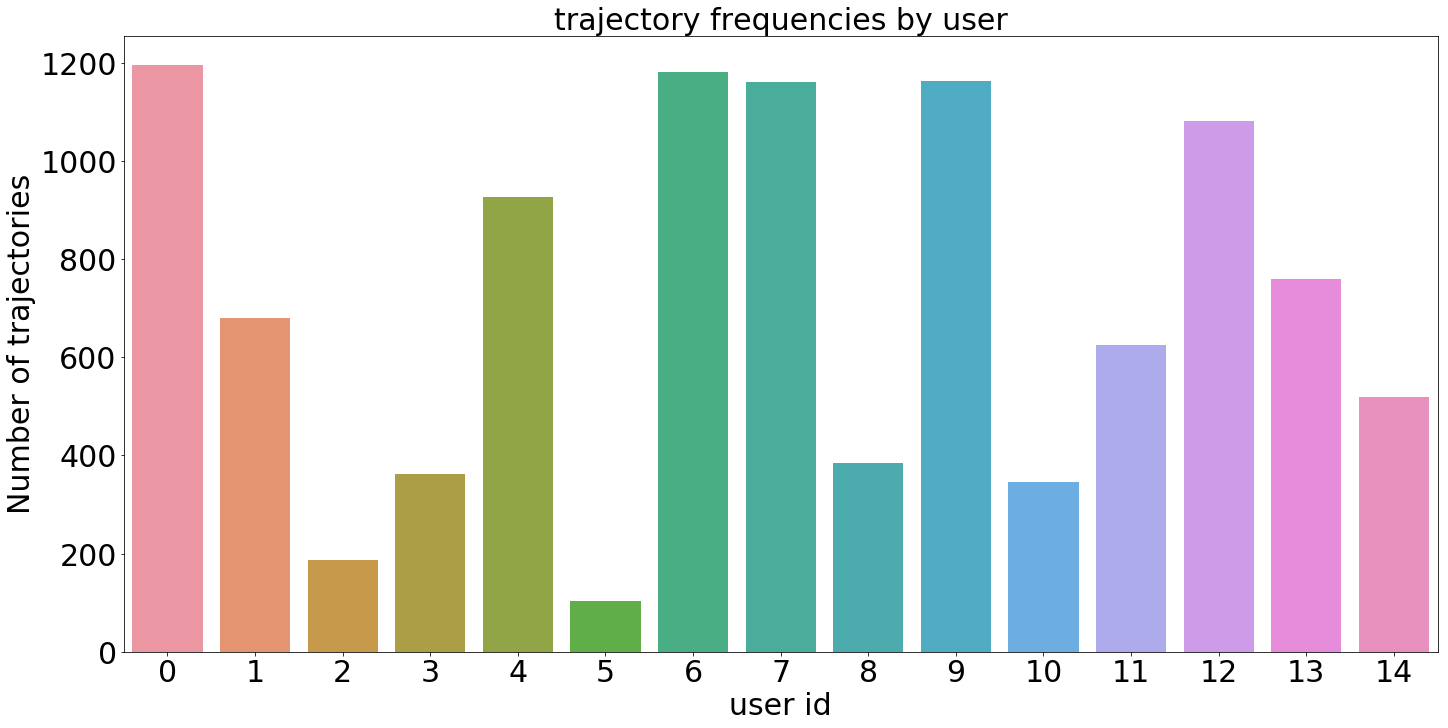

In [3]:
show_trajectory_frequencies_by_user(trajectories_df)

## Data Reading

The user touch data in JSON format from all the ShapeMatch game rounds stored in the 'data' directory are displayed in a list of dictionaries. Each dictionary row in the list represents a trajectory containing the following attributes: 

**figures**: list of figures matched by the trajectory. For each figure there is an array with three positions. The index 0 corresponds to the position in the x-coordinate. The index 1 corresponds to the position in the y-coordinate and the index 2 corresponds to the moment in which the figure was paired.

**Group**: the group to which the trajectory belongs

**id**: the unique id of the trajectory

**time**: array containing the creation time of each point in the trajectory

**x**: array containing the x-axis position of each point in the trajectory

**y**: array containing the position on the y-axis of each point of the trajectory

**uid1**: (integer) id of player 1

**uid2**: (integer) id of player 2 (in case of a multiplayer round)


In [4]:
random_subset = trajectories_df.sample(n=3)  # Random trajectories to tabulate
random_subset.head(3)

,figures,group,id,time,uid1,uid1String,uid2,uid2String,x,y
4340,"[[0.4148143231868744, 0.15909093618392944], [0...",159,4341,"[0.0, 0.066680908203125, 0.0999755859375, 0.13...",6,Christian,,,"[0.41434845328330994, 0.4260614812374115, 0.44...","[0.12646484375, 0.14892578125, 0.18408203125, ..."
7053,"[[0.3296286463737488, 0.8787878155708313], [0....",363,7054,"[0.0, 0.06536865234375, 0.0987396240234375, 0....",9,Alex,12,Irene,"[0.3243045508861542, 0.32613471150398254, 0.34...","[0.8935546875, 0.896484375, 0.888671875, 0.879..."
3613,"[[0.4148143231868744, 0.6136363744735718], [0....",97,3614,"[0.0, 0.033477783203125, 0.066741943359375, 0....",9,Alex,,,"[0.40995606780052185, 0.3964128792285919, 0.36...","[0.6220703125, 0.62548828125, 0.6279296875, 0...."


## Grouping and Sorting:

The trajectories are grouped according to the positions of the paired figures. A metadata dictionary is created showing general information about each group of trajectories. The metadata dictionary has the following attributes:

**group**: The unique id of the group of trajectories

**users**: List of tuples (user id, number of trajectories) belonging to the group which is sorted by the performed number of trajectories.

**trajectories**: The total number of trajectories belonging to the group

The groups are sorted according to the number of trajectories contained in each one

In [5]:
trajectory_groups = get_trajectory_groups(trajectories) # metadata of the trajectory groups
sorted_trajectory_groups = sort_trajectory_groups_according_to_quantity_of_trajectories(trajectory_groups) #returns a list
sorted_trajectory_groups[0] # index 0 corresponds to the group of trajectories with the highest number of trajectories

{'group': 46,
 'users': [(7, 12),
  (6, 12),
  (12, 12),
  (4, 11),
  (0, 10),
  (9, 10),
  (1, 9),
  (11, 8),
  (13, 7),
  (5, 3),
  (14, 3),
  (8, 3),
  (3, 2),
  (10, 2)],
 'trajectories': 104}

In [6]:
#lists the trayectories belonging to a specific group according to userid keys
group_trajectories_by_user = get_group_trajectories_by_user(trajectories,sorted_trajectory_groups[0]['group'])

## Explanation of methods using two paths

We use two trajectories belonging to the same group and created by the same user to give a step-by-step explanation of the analysis carried out in the study.

You can skip this explanation and go directly to the analysis of the results by applying the DTWD and DTWI methods in different groups of trajectories described much further down in the script.

In [7]:
trajectories_to_plot = group_trajectories_by_user[3][:2] # gets the first two trajectories generated by user 1

## Graphing the time series

The following three plots show the spatial positions of the x and y sequences of 2 time series of a specific group created by a single user. Notice that in the third graph the minuscule displacements of the x spatial position become more noticeable when both sets of sequences (x and y) are shown in the same graph. 

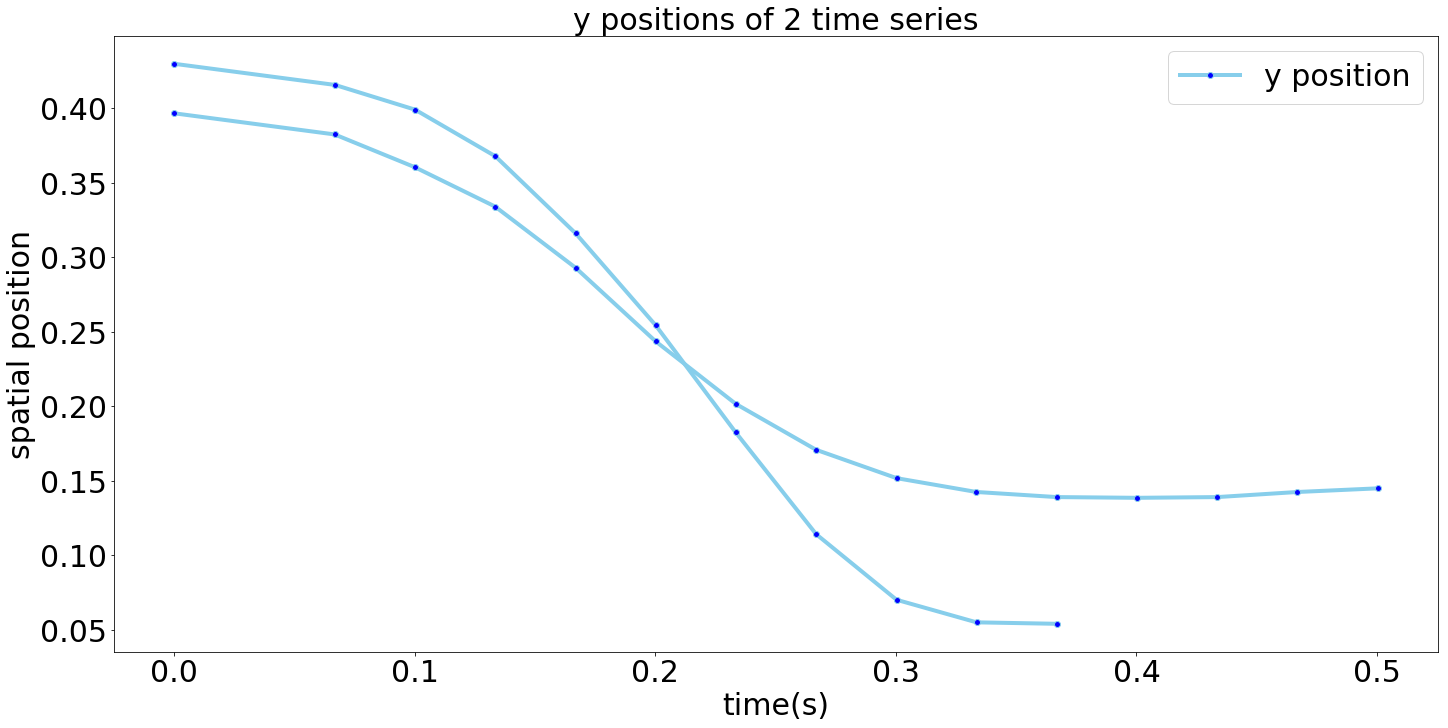

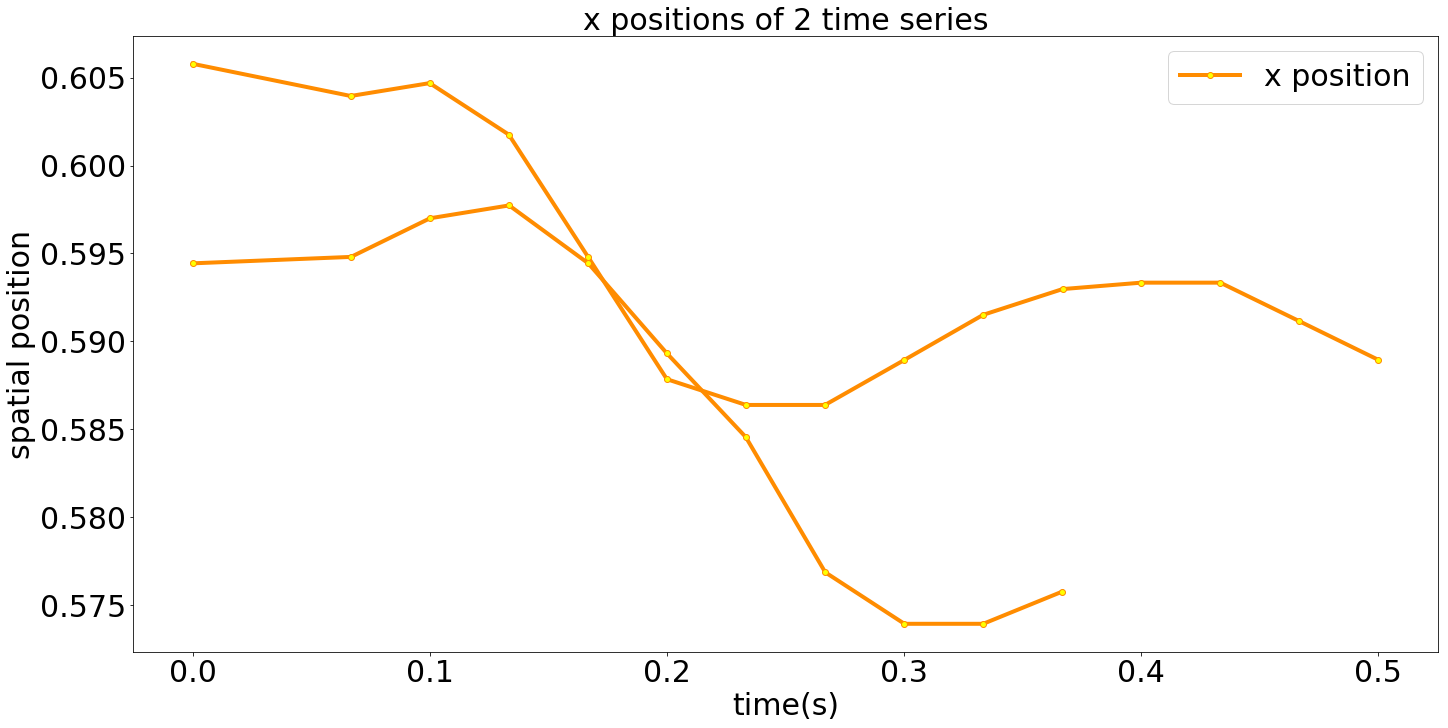

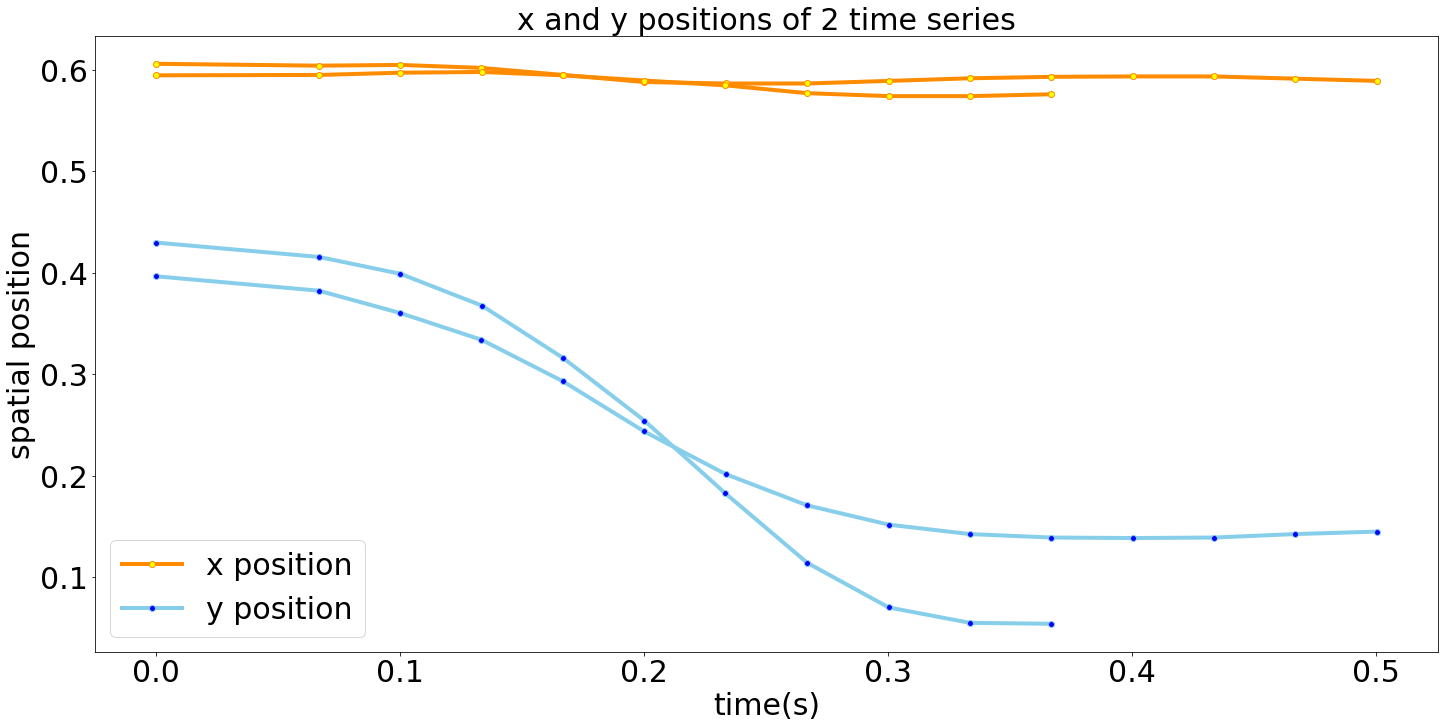

In [8]:
plot_trajectories(trajectories_to_plot,x_values=False)
plot_trajectories(trajectories_to_plot,y_values=False)
plot_trajectories(trajectories_to_plot)


## Time Series Normalization

Handles the elimination of unwanted shifts between time series by enabling the DTW algorithm to focus on the structural similarities/dissimilarities of the time series rather than on unwanted amplitudes. We perform normalization of time sequences in order to determine if this has an implication in the final outcome when the multidimensional DTW algorithm is being applied in its different varieties.

The procedure transforms the sequence values of the time series in such a way that the standard deviation has an approximate value of 1 and an approximate mean of 0. This value is obtained by subtracting the original value of each sequence by the mean and then dividing the standard value of the time series. The following formula describes normalization given an index i belonging to the sequence of the time series:


$$x_{i}' = \frac{x_{i} - \mu }{\sigma } $$



In [9]:
normalized_trajectories_to_plot = copy.deepcopy(trajectories_to_plot)

for trajectory in normalized_trajectories_to_plot:
    normalized_x = z_normalize(trajectory['x'])
    normalized_y = z_normalize(trajectory['y'])
    trajectory['x'] = normalized_x
    trajectory['y'] = normalized_y

## Graphing the z-normalized time series

Now that the time series are shifted in a similar location along the y-axis we proceed to graph the same previously plotted trajectories. 

Note that now the normalized values for the positions on the x-axis have a greater amplitude causing a slight suspicion of inefficiency when it comes to the application of the similarity algorithm. This suspicion can be inferred from the apparent high level of volatility being shown in comparison with the same time series with no such normalization treatment. 

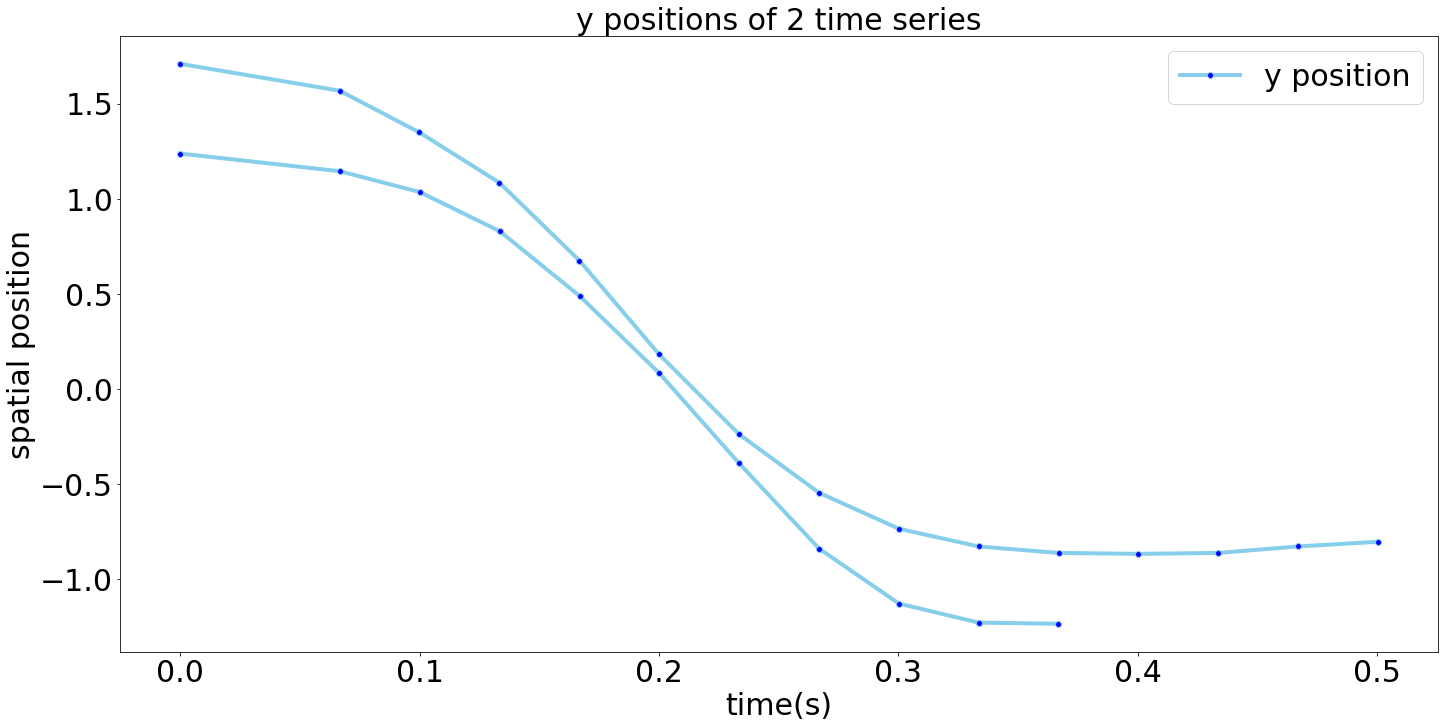

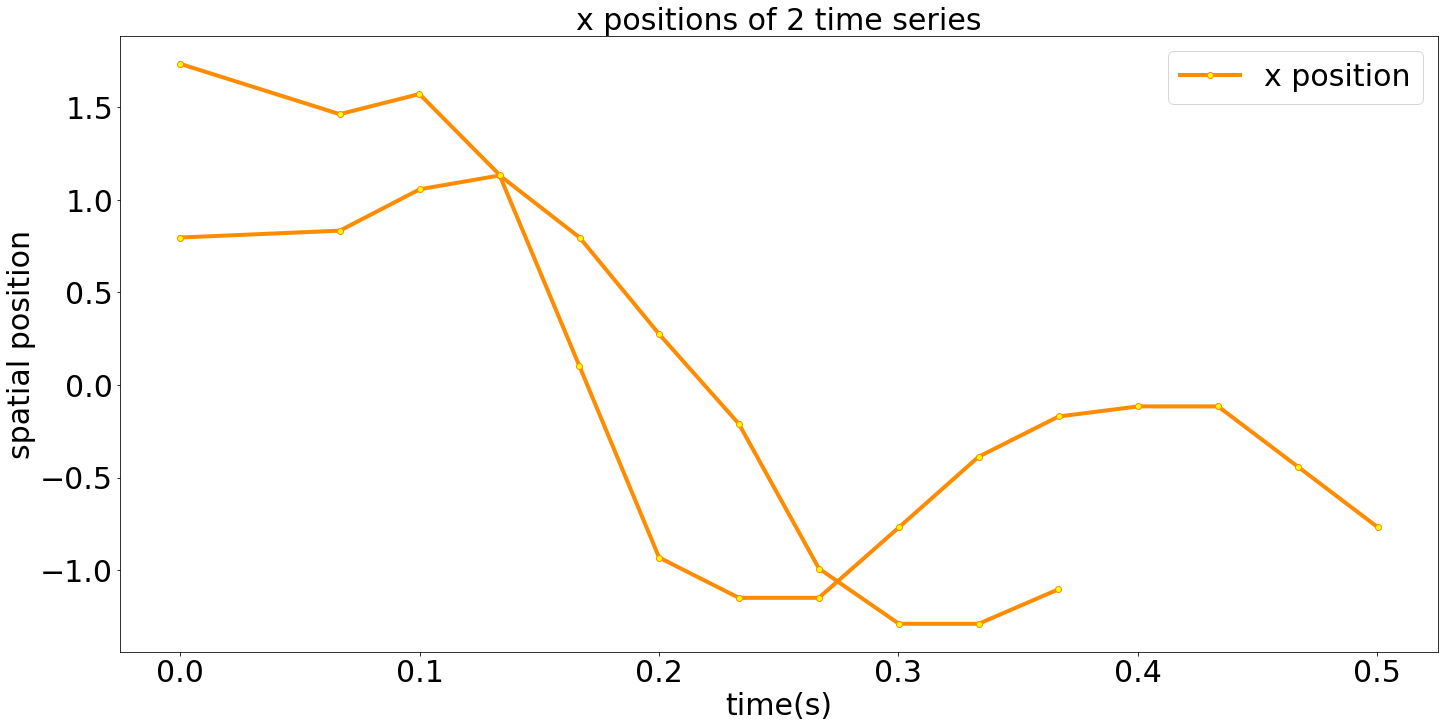

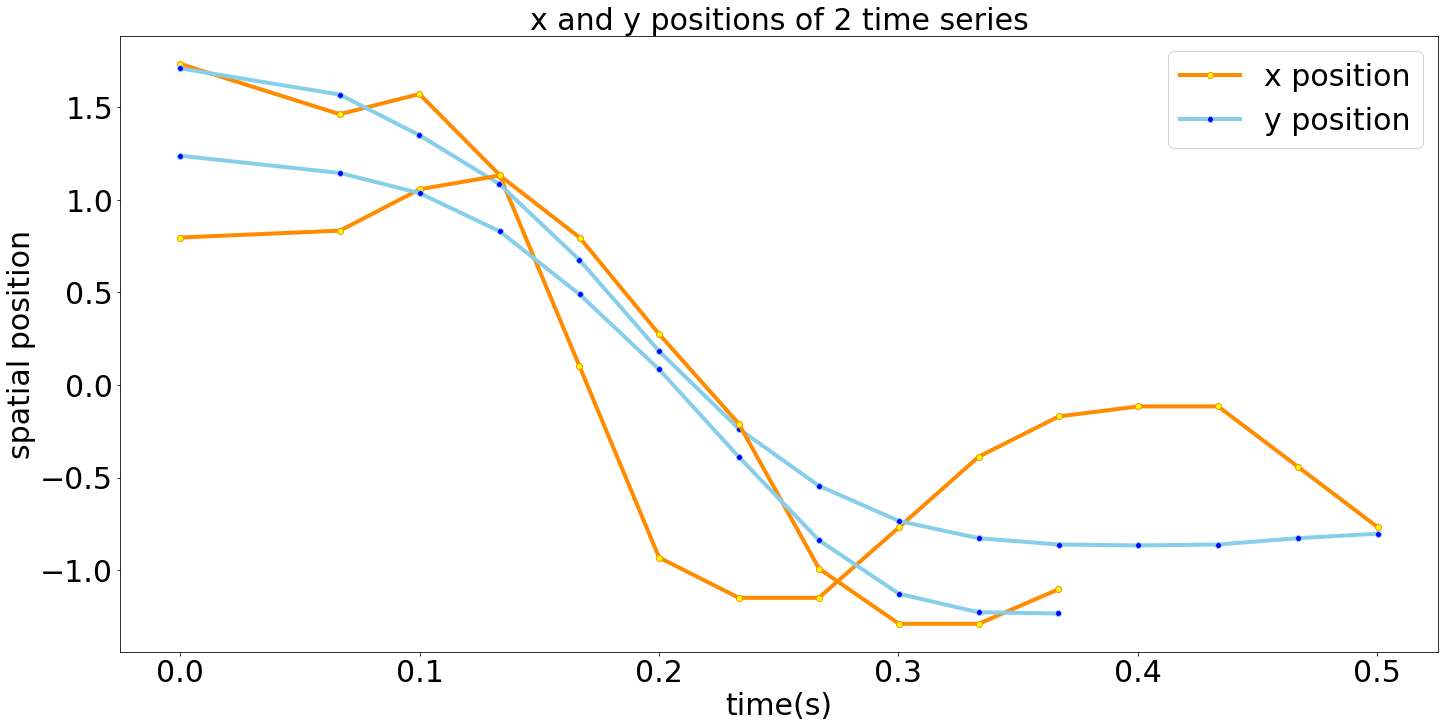

In [10]:
plot_trajectories(normalized_trajectories_to_plot,x_values=False)
plot_trajectories(normalized_trajectories_to_plot,y_values=False)
plot_trajectories(normalized_trajectories_to_plot)

In [11]:
for trajectory in trajectories_to_plot:
    trajectory['xy_vectors'] = vectorize_x_and_y_time_series_values(trajectory['x'], trajectory['y'])
for trajectory in normalized_trajectories_to_plot:
    trajectory['xy_vectors'] = vectorize_x_and_y_time_series_values(trajectory['x'], trajectory['y'])

## x and and y time series vectorization

Each trajectory ${T}$ is composed of two spatial time series $X$ and $Y$ of length $|{T}|$ each . Our DTW method can perform multidimensional operations provided that each multidimensional sequence is represented as a vector in n-dimensions.

$$ \vec{v_{i}} =  \binom{x_{i}}{y_{i}} \text{ with } i \geq 0 \leq  {|T|} $$


We map the values of each $x_{i}$ and $y_{i}$ Time series sequences as numpy.array vectors

## DTW Calculation

Below we present the DTW calculation for the above trajectories. For more information on how this calculation works please refer to the documentation attached with this script or visit the following link: [Dynamic Time Warping Algorithm](https://en.wikipedia.org/wiki/Dynamic_time_warping "DTW in Wikipedia")


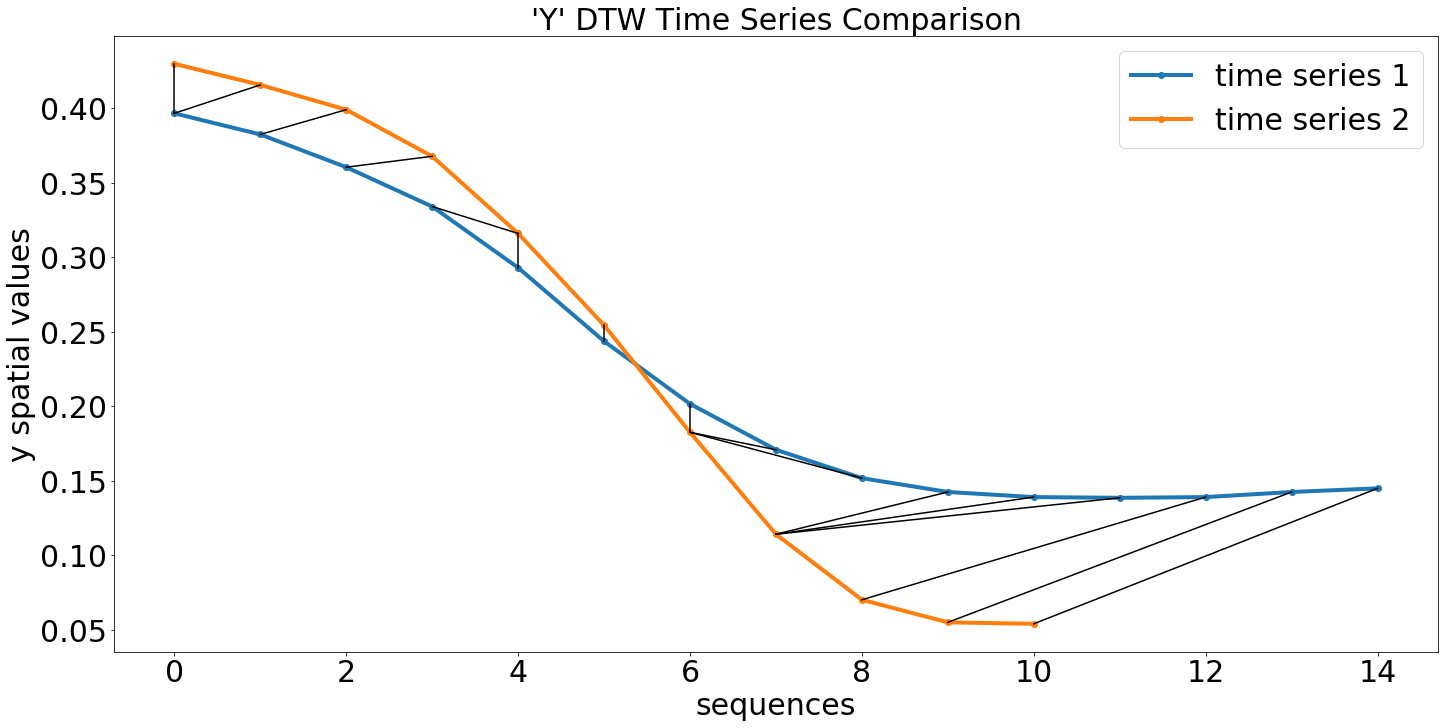

In [12]:
t1_y = trajectories_to_plot[0]['y'] # y time series of the first trajectory
t2_y = trajectories_to_plot[1]['y'] # y time series of the second trajectory

# DTW calculation of both time series 'y' of the sample trajectories
matches, cost, mapping_1, mapping_2, matrix = dtw(t1_y, t2_y)

# DTW plot of the y-dimension between both paths
plot_dtw(t1_y,t2_y,title="'Y' DTW Time Series Comparison", ylabel="y spatial values")

The acumulated distance of the (optimal) warping path is: 0.5142



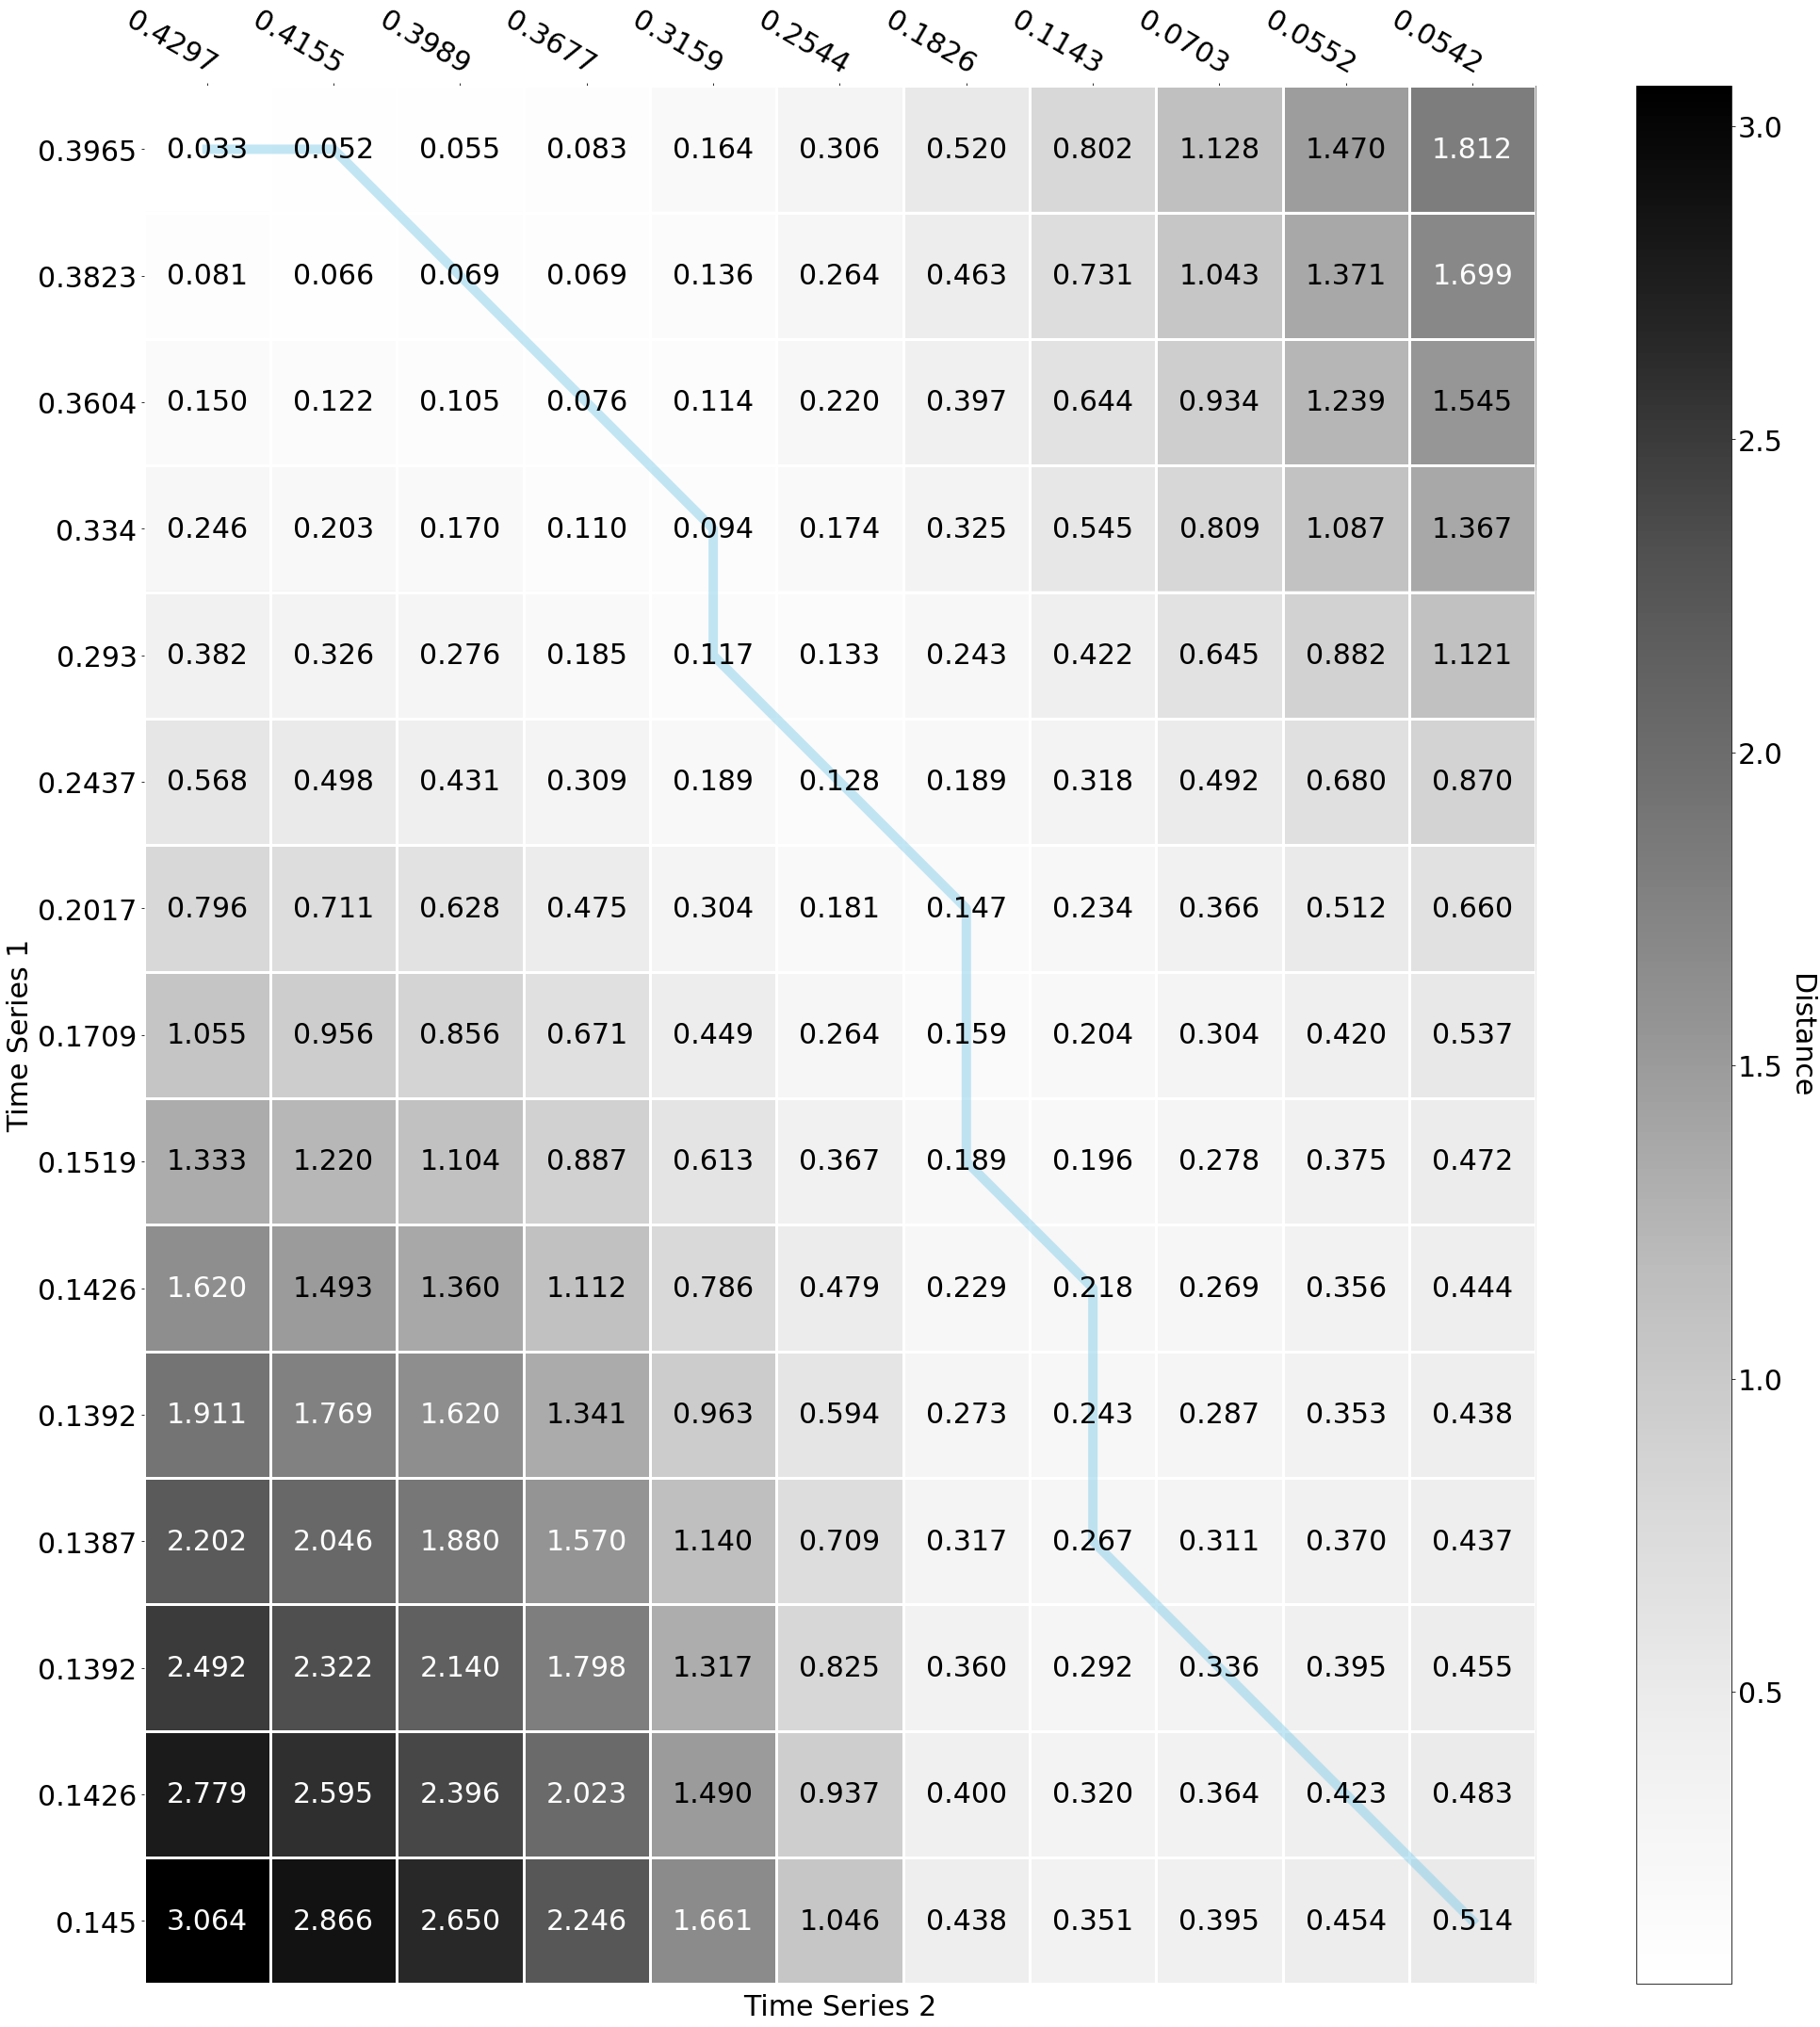

In [13]:
print("The acumulated distance of the (optimal) warping path is: " + str(round(cost, 4))+"\n")
plot_distance_matrix_from_time_series(t1_y, t2_y)

## Extending DTW to Multidimensional Data

As explained before because our data set is composed of multidimensional trajectories (understood as two time series $X$ and $Y$ per trajectory) we will use two DTW approaches known as DTWD <em>(which means dependent)</em> and DTWI <em>(which means independent)</em> in order to determine with the help of the results which of the two is most appropriate for the identification of desired similarities:

**Independent Multidimensional Dynamic Time Warping (DTWI)**

The DTWI is obtained by computing the DTW of each of the dimensions from both trajectories thus generating two distance matrices. Finally, the accumulated distances of both warping paths are adhered obtaining the similarity value. The DTWI can be described by the following equation:

$$ DTW_{I}\left ( T_{1},T_{2} \right ) = DTW\left ( T_{1x},T_{2x} \right ) +DTW\left ( T_{1y},T_{2y}\right ) $$

**Dependent Multidimensional Dynamic Time Warping (DTWD)**

The DTWD is obtained by almost following the same methodology as with DTW but additionally the distances among the n-dimensions sequences from both trajectories are measured. Notice that the $x$ and $y$ sequences from both time series present in each Trajectory are now represented as vectors. We previously used numpy to map the time series $x_{i}$ and $x_{i}$ as vectors, this allows us to determine the distance between the two sequences of the two trajectories in form of a vector subtraction. The DTWD can be described by the following equation:

$$ DTW_{D}\left ( T_{1},T_{2} \right ) = DTW\left ( \binom{T_{1x}}{T_{1y}},  \binom{T_{2x}}{T_{2y}}\right ) $$

## Calculation of DTWD and DTWI 
For the calculation of the DTWD and DTWI we make use of the method `calculate_dtwd_and_dtwi_from_time_series_list()` which performs the calculation of the attributes <em>(<strong>matches:</strong> Warping path, <strong>cost:</strong>  Accumulate distance, <strong>mapping_1:</strong> Matched secuences indices of series 1 to series 2, <strong>mapping_2:</strong> Matched secuences indices of series 2 to series 1, and <strong>matrix:</strong> $(|T_{1}|, |T_{2}|)$ sequence distances)</em> for both DTW modalities according to both the time series <em>x</em> and <em>y</em> and their z-normalized varieties.

Particularly interesting is the comparison of the DTWD and DTWI accumulated distances across the points that make up their warping paths, as this is the main indicator for determining the degree of similarity/dissimilarity between the two trajectories.

In [96]:
_dtwi_dtwd = dtwd_dtwi(trajectories_to_plot[0],trajectories_to_plot[1])
print('trajectory ids: ' + str(_dtwi_dtwd['trajectory_ids']))
print('user ids: ' + str(_dtwi_dtwd['user_ids']))

print('************| DTW |************')
print('DTW accumulated \'x\' distance: ' + str(_dtwi_dtwd['dtwi']['x']['cost']))
print('DTW accumulated \'x-normalized\' distance: '+ str(_dtwi_dtwd['dtwi']['normalized_x']['cost']))
print('DTW accumulated \'y\' distance: ' + str(_dtwi_dtwd['dtwi']['y']['cost']))
print('DTW accumulated \'y-normalized\' distance: ' + str(_dtwi_dtwd['dtwi']['normalized_y']['cost']))

print('************| DTWD |************')
print('DTWD \'x\' and \'y\' accumulated distance: ' + str(_dtwi_dtwd['dtwd']['cost']))
print('DTWD \'x-normalized\' and \'y-normalized\' accumulated distance: ' + str(_dtwi_dtwd['normalized_dtwd']['cost']))

print('************| DTWI |************')
print('DTWI accumulated distance by adding both DTW \'x\' and \'y\' accumulated distances: ' + str(_dtwi_dtwd['dtwi']['x']['cost'] + _dtwi_dtwd['dtwi']['y']['cost']))
print('DTWI accumulated distance by adding both DTW \'x-normalized\' and \'y-normalized\' accumulated distances: ' + str(_dtwi_dtwd['dtwi']['normalized_y']['cost'] + _dtwi_dtwd['dtwi']['normalized_x']['cost']))


trajectory ids: [383, 477]
user ids: [3, 3]
************| DTW |************
DTW accumulated 'x' distance: 0.11566615104675293
DTW accumulated 'x-normalized' distance: 7.994961556956176
DTW accumulated 'y' distance: 0.51416015625
DTW accumulated 'y-normalized' distance: 3.0308080616224644
************| DTWD |************
DTWD 'x' and 'y' accumulated distance: 0.5438901015706452
DTWD 'x-normalized' and 'y-normalized' accumulated distance: 11.076411712465942
************| DTWI |************
DTWI accumulated distance by adding both DTW 'x' and 'y' accumulated distances: 0.6298263072967529
DTWI accumulated distance by adding both DTW 'x-normalized' and 'y-normalized' accumulated distances: 11.025769618578641


## performing DTW in its two modalities (DTWD and DTWI) along trajectories belonging to the same group

For this second part we calculate the DTWD and DTWI for a wider set of trajectories. 104 trajectories belonging to the same group and created by 14 users have been compared. In order to measure the degree of similarity/dissimilarity among them, the statistical measures of mean and standard deviation have been used in order to determine the dispersion degree of the resulting warping path distances for both the original an z-normalized time series values. The analysis of patterns between trajectories has been undertaken in the following cases:

1.	 DTWD and DTWI warping path distance calculations between trajectories created by a single user (the two players with the highest number of trajectories created in that group were compared individually)

2.	DTWD and DWTI warping path distance calculations between trajectories created by two users (comparisons of trajectories with the same user id excluded)

3.	DTWD and DTWI warping path distance calculations between trajectories created by all users of the group (comparisons of trajectories with the same user id excluded)

We show the results derived from the analysis for the three scenarios by means of the original and z-normalized time series values. Several graphical illustrations are also provided showing how the distances are distributed for each comparison case:

In [43]:
trajectory_groups = get_trajectory_groups(trajectories) # metadata of the trajectory groups
sorted_trajectory_groups = sort_trajectory_groups_according_to_quantity_of_trajectories(trajectory_groups) #returns a sorted list by number of trajectories per group
print('*** | Group A Metadata |***')
print(sorted_trajectory_groups[0]) # index 0 corresponds to the group of trajectories with the highest number of trajectories
group_A_id = sorted_trajectory_groups[0]['group']
group_A_trajectories = get_list_of_trajectories_by_group(trajectories, group_A_id)


*** | Group A Metadata |***
{'group': 46, 'users': [(7, 12), (6, 12), (12, 12), (4, 11), (0, 10), (9, 10), (1, 9), (11, 8), (13, 7), (5, 3), (14, 3), (8, 3), (3, 2), (10, 2)], 'trajectories': 104}


In [16]:
# DTWI and DTWD Distances for Group A
group_A_DTW_comparisons = dtwd_and_dtwi_distances_between_trajectories(group_A_trajectories)

In [44]:
# Filtered DTW comparisons for Group A
group_A_user_1 = sorted_trajectory_groups[0]['users'][0][0] #(user's tuple) index 0: uid , index 1: number of trajectories
group_A_user_2 = sorted_trajectory_groups[0]['users'][1][0] #(user's tuple) index 0: uid , index 1: number of trajectories
group_A_user_1_DTW_trajectory_comparisons = [dtw_dtwi for dtw_dtwi in group_A_DTW_comparisons if dtw_dtwi['user_ids'][0] == group_A_user_1 and dtw_dtwi['user_ids'][1] == group_A_user_1 ]
group_A_user_2_DTW_trajectory_comparisons = [dtw_dtwi for dtw_dtwi in group_A_DTW_comparisons if dtw_dtwi['user_ids'][0] == group_A_user_2 and dtw_dtwi['user_ids'][1] == group_A_user_2 ]
group_A_user_1_and_user_2_DTW_trajectory_comparisons = [dtw_dtwi for dtw_dtwi in group_A_DTW_comparisons if group_A_user_1 in dtw_dtwi['user_ids'] and group_A_user_2 in dtw_dtwi['user_ids']] # Excluding DTW comparisons of trajectories performed by the same user
group_A_DTW_trajectory_comparisons_among_users = [dtw_dtwi for dtw_dtwi in group_A_DTW_comparisons if dtw_dtwi['user_ids'][0] != dtw_dtwi['user_ids'][1]] # DTW Trajectory comparisons excluding comparisons of trajectories performed by the same user

In [82]:
mean_and_stdev_dict = calculate_mean_and_standard_deviation_of_DTWD_DTWI_Comparisons(group_A_user_1_DTW_trajectory_comparisons)

print('***** | Group A | *****' + '\n')
print('***** | Mean and Standard deviation of DTWD and DTWI comparisons within Player 1 | *****' + '\n')
print('mean_dtwd: ' + str(mean_and_stdev_dict['mean_dtwd']))
print('mean_dtwi: ' + str(mean_and_stdev_dict['mean_dtwi']))
print('stdev_dtwi: ' + str(mean_and_stdev_dict['stdev_dtwi']))
print('stdev_dtwd: ' + str(mean_and_stdev_dict['stdev_dtwd']))

print('mean_dtwd_normalized: ' + str(mean_and_stdev_dict['mean_dtwd_normalized']))
print('mean_dtwi_normalized: ' + str(mean_and_stdev_dict['mean_dtwi_normalized']))
print('stdev_dtwd_normalized: ' + str(mean_and_stdev_dict['stdev_dtwd_normalized']))
print('stdev_dtwi_normalized: ' + str(mean_and_stdev_dict['stdev_dtwi_normalized']))

***** | Group A | *****

***** | Mean and Standard deviation of DTWD and DTWI comparisons within Player 1 | *****

mean_dtwd: 0.7813533122183259
mean_dtwi: 0.8556973943204591
stdev_dtwi: 0.7404273547640626
stdev_dtwd: 0.7106918822733598
mean_dtwd_normalized: 11.743280487960721
mean_dtwi_normalized: 13.830338738479268
stdev_dtwd_normalized: 6.889774874888306
stdev_dtwi_normalized: 9.451615786914068


In [62]:
mean_and_stdev_dict = calculate_mean_and_standard_deviation_of_DTWD_DTWI_Comparisons(group_A_user_2_DTW_trajectory_comparisons)
print('***** | Group A | *****' + '\n')
print('***** | Mean and Standard deviation of DTWD and DTWI comparisons within Player 2 | *****' + '\n')
print('mean_dtwd: ' + str(mean_and_stdev_dict['mean_dtwd']))
print('mean_dtwi: ' + str(mean_and_stdev_dict['mean_dtwi']))
print('stdev_dtwi: ' + str(mean_and_stdev_dict['stdev_dtwi']))
print('stdev_dtwd: ' + str(mean_and_stdev_dict['stdev_dtwd']))
print('mean_dtwd_normalized: ' + str(mean_and_stdev_dict['mean_dtwd_normalized']))
print('mean_dtwi_normalized: ' + str(mean_and_stdev_dict['mean_dtwi_normalized']))
print('stdev_dtwd_normalized: ' + str(mean_and_stdev_dict['stdev_dtwd_normalized']))
print('stdev_dtwi_normalized: ' + str(mean_and_stdev_dict['stdev_dtwi_normalized']))

***** | Group A | *****

***** | Mean and Standard deviation of DTWD and DTWI comparisons within Player 2 | *****

mean_dtwd: 1.0813322262078773
mean_dtwi: 1.1591619189941522
stdev_dtwi: 0.9431855869967943
stdev_dtwd: 0.905397411443093
mean_dtwd_normalized: 14.172176216990794
mean_dtwi_normalized: 16.715745525328426
stdev_dtwd_normalized: 7.609575945031861
stdev_dtwi_normalized: 10.738659382748072


In [63]:
mean_and_stdev_dict = calculate_mean_and_standard_deviation_of_DTWD_DTWI_Comparisons(group_A_user_1_and_user_2_DTW_trajectory_comparisons)
print('***** | Group A | *****' + '\n')
print('***** | Mean and Standard deviation of DTWD and DTWI comparisons between Players 1 and 2 | *****' + '\n')
print('mean_dtwd: ' + str(mean_and_stdev_dict['mean_dtwd']))
print('mean_dtwi: ' + str(mean_and_stdev_dict['mean_dtwi']))
print('stdev_dtwi: ' + str(mean_and_stdev_dict['stdev_dtwi']))
print('stdev_dtwd: ' + str(mean_and_stdev_dict['stdev_dtwd']))

print('mean_dtwd_normalized: ' + str(mean_and_stdev_dict['mean_dtwd_normalized']))
print('mean_dtwi_normalized: ' + str(mean_and_stdev_dict['mean_dtwi_normalized']))
print('stdev_dtwd_normalized: ' + str(mean_and_stdev_dict['stdev_dtwd_normalized']))
print('stdev_dtwi_normalized: ' + str(mean_and_stdev_dict['stdev_dtwi_normalized']))

***** | Group A | *****

***** | Mean and Standard deviation of DTWD and DTWI comparisons between Players 1 and 2 | *****

mean_dtwd: 0.9309154682562654
mean_dtwi: 1.0066837548381753
stdev_dtwi: 0.7991936867543682
stdev_dtwd: 0.7655870451098625
mean_dtwd_normalized: 12.696847225716358
mean_dtwi_normalized: 14.993596054666368
stdev_dtwd_normalized: 7.214092741536165
stdev_dtwi_normalized: 9.97623964552887


In [64]:
mean_and_stdev_dict = calculate_mean_and_standard_deviation_of_DTWD_DTWI_Comparisons(group_A_DTW_trajectory_comparisons_among_users)
print('***** | Group A | *****' + '\n')
print('***** | Mean and Standard deviation of DTWD and DTWI comparisons between all users | *****' + '\n')
print('mean_dtwd: ' + str(mean_and_stdev_dict['mean_dtwd']))
print('mean_dtwi: ' + str(mean_and_stdev_dict['mean_dtwi']))
print('stdev_dtwi: ' + str(mean_and_stdev_dict['stdev_dtwi']))
print('stdev_dtwd: ' + str(mean_and_stdev_dict['stdev_dtwd']))

print('mean_dtwd_normalized: ' + str(mean_and_stdev_dict['mean_dtwd_normalized']))
print('mean_dtwi_normalized: ' + str(mean_and_stdev_dict['mean_dtwi_normalized']))
print('stdev_dtwd_normalized: ' + str(mean_and_stdev_dict['stdev_dtwd_normalized']))
print('stdev_dtwi_normalized: ' + str(mean_and_stdev_dict['stdev_dtwi_normalized']))

***** | Group A | *****

***** | Mean and Standard deviation of DTWD and DTWI comparisons between all users | *****

mean_dtwd: 0.8980963634235571
mean_dtwi: 0.9764170327369871
stdev_dtwi: 0.8744915002968594
stdev_dtwd: 0.8376692062481681
mean_dtwd_normalized: 13.68017733378646
mean_dtwi_normalized: 15.089106530111371
stdev_dtwd_normalized: 7.773191302346383
stdev_dtwi_normalized: 9.710765170888196


### DTW of paths created by the same user

For our comparison by group of trajectories (here called group A) we use the first two players with the highest number of trajectories created in the group.

Below we present the graphs of the accumulated distances DTWD and DTWI of both the original and z-normalized values of the trajectories created by the same user. 

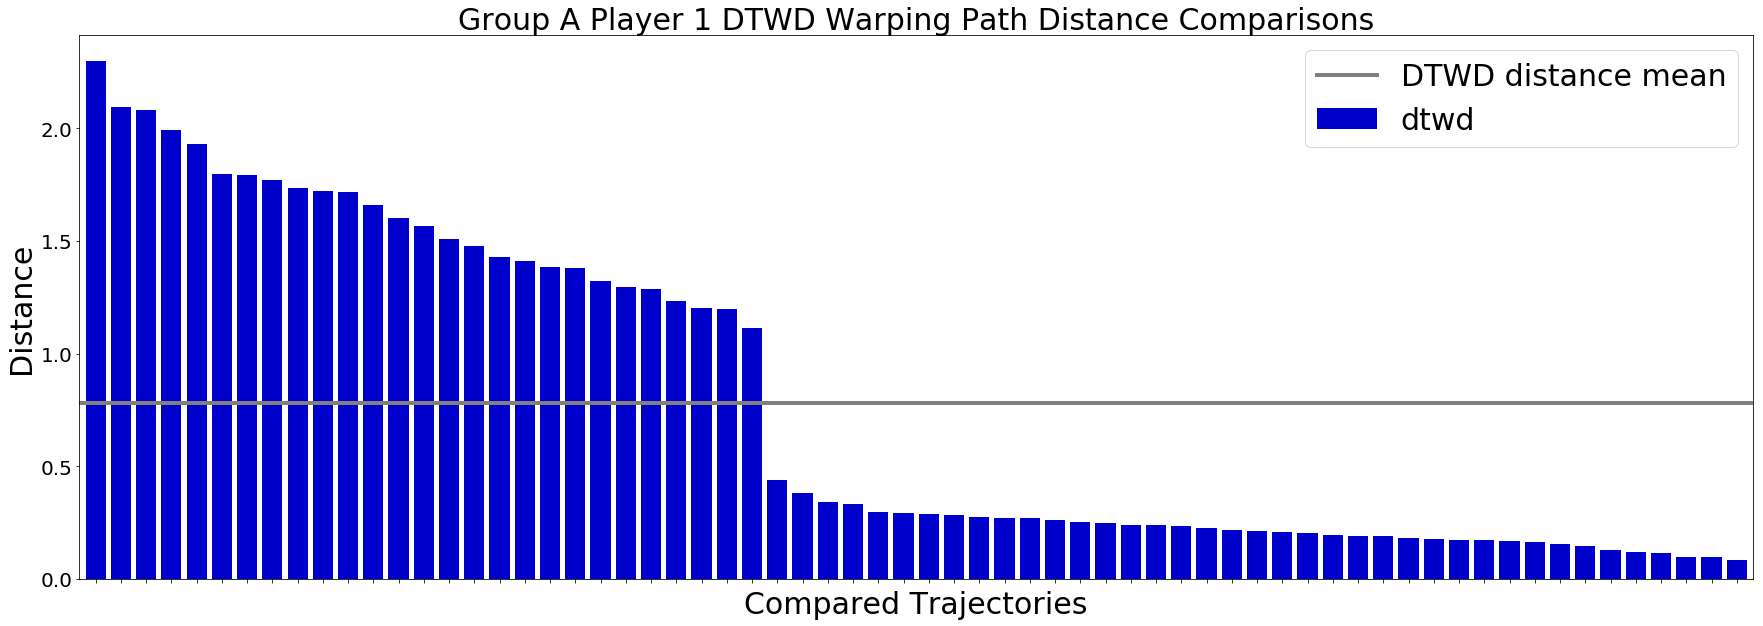

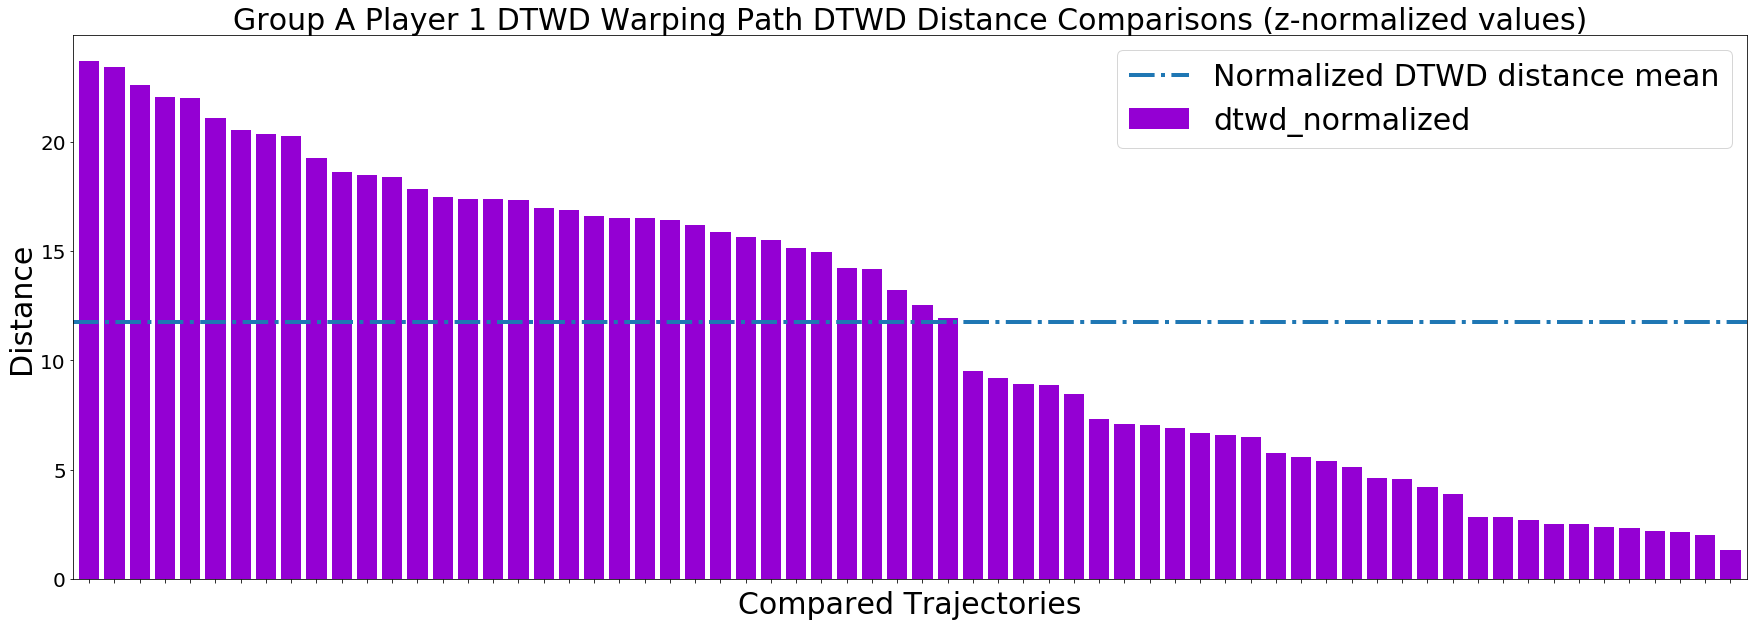

In [100]:
plot_dtwd_dtwi_occurrencies(group_A_user_1_DTW_trajectory_comparisons, title="Group A Player 1 DTWD Warping Path Distance Comparisons", dtwd=True, dtwi=False, dtwd_normalized=False,dtwi_normalized=False)
plot_dtwd_dtwi_occurrencies(group_A_user_1_DTW_trajectory_comparisons, title="Group A Player 1 DTWD Warping Path DTWD Distance Comparisons (z-normalized values)", dtwd=False, dtwi=False, dtwd_normalized=True,dtwi_normalized=False)

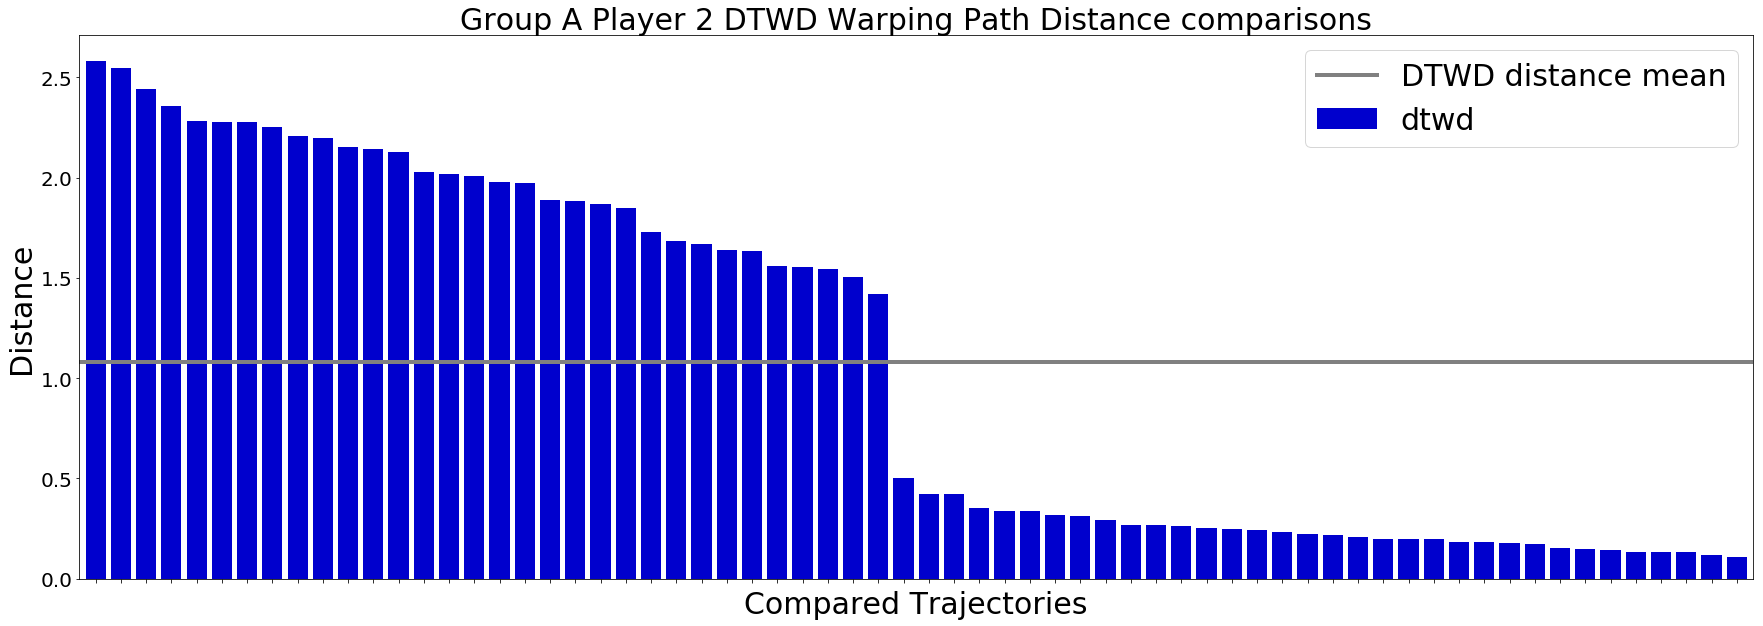

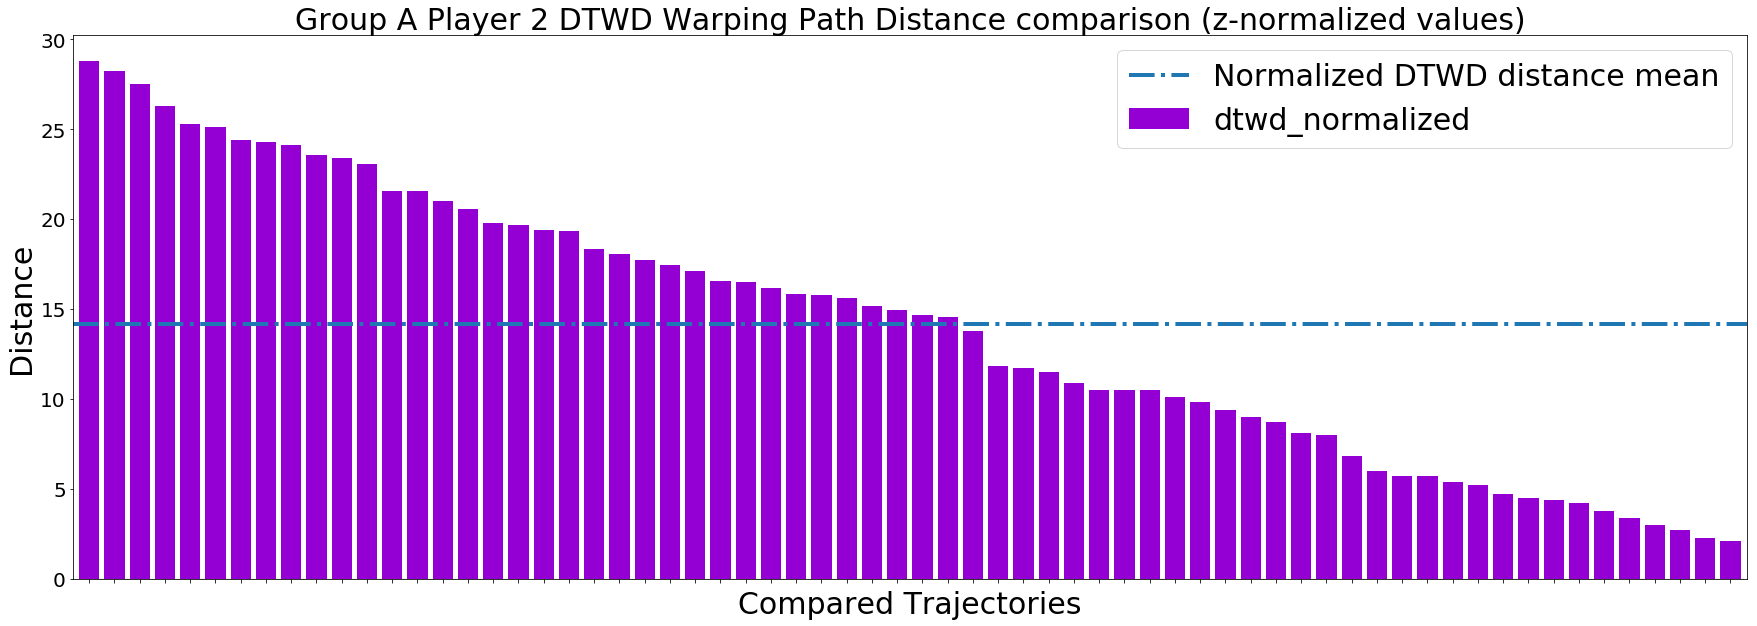

In [101]:
plot_dtwd_dtwi_occurrencies(group_A_user_2_DTW_trajectory_comparisons, title="Group A Player 2 DTWD Warping Path Distance comparisons", dtwd=True, dtwi=False, dtwd_normalized=False,dtwi_normalized=False)
plot_dtwd_dtwi_occurrencies(group_A_user_2_DTW_trajectory_comparisons, title="Group A Player 2 DTWD Warping Path Distance comparison (z-normalized values)", dtwd=False, dtwi=False, dtwd_normalized=True,dtwi_normalized=False)

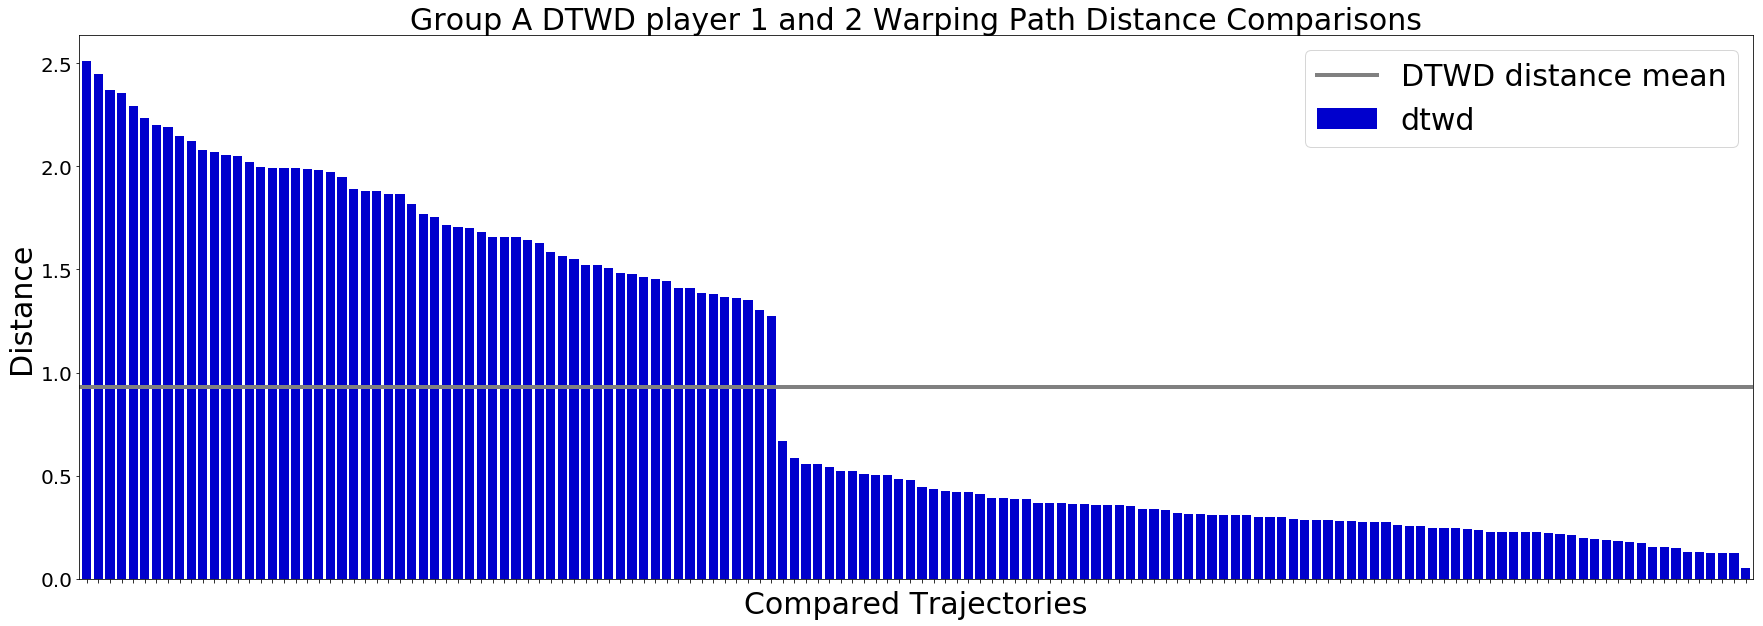

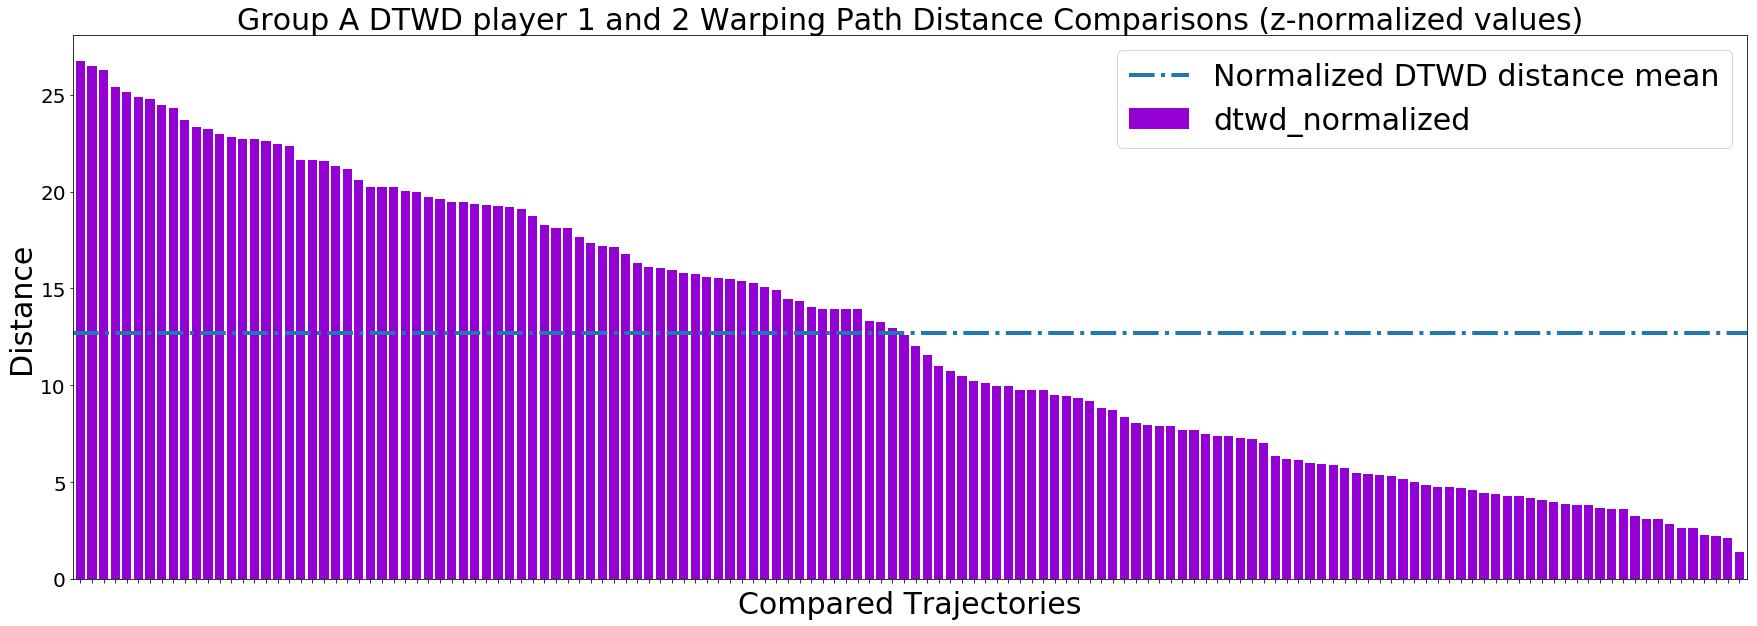

In [102]:
plot_dtwd_dtwi_occurrencies(group_A_user_1_and_user_2_DTW_trajectory_comparisons, title="Group A DTWD player 1 and 2 Warping Path Distance Comparisons", dtwd=True, dtwi=False, dtwd_normalized=False,dtwi_normalized=False)
plot_dtwd_dtwi_occurrencies(group_A_user_1_and_user_2_DTW_trajectory_comparisons, title="Group A DTWD player 1 and 2 Warping Path Distance Comparisons (z-normalized values)", dtwd=False, dtwi=False, dtwd_normalized=True,dtwi_normalized=False)

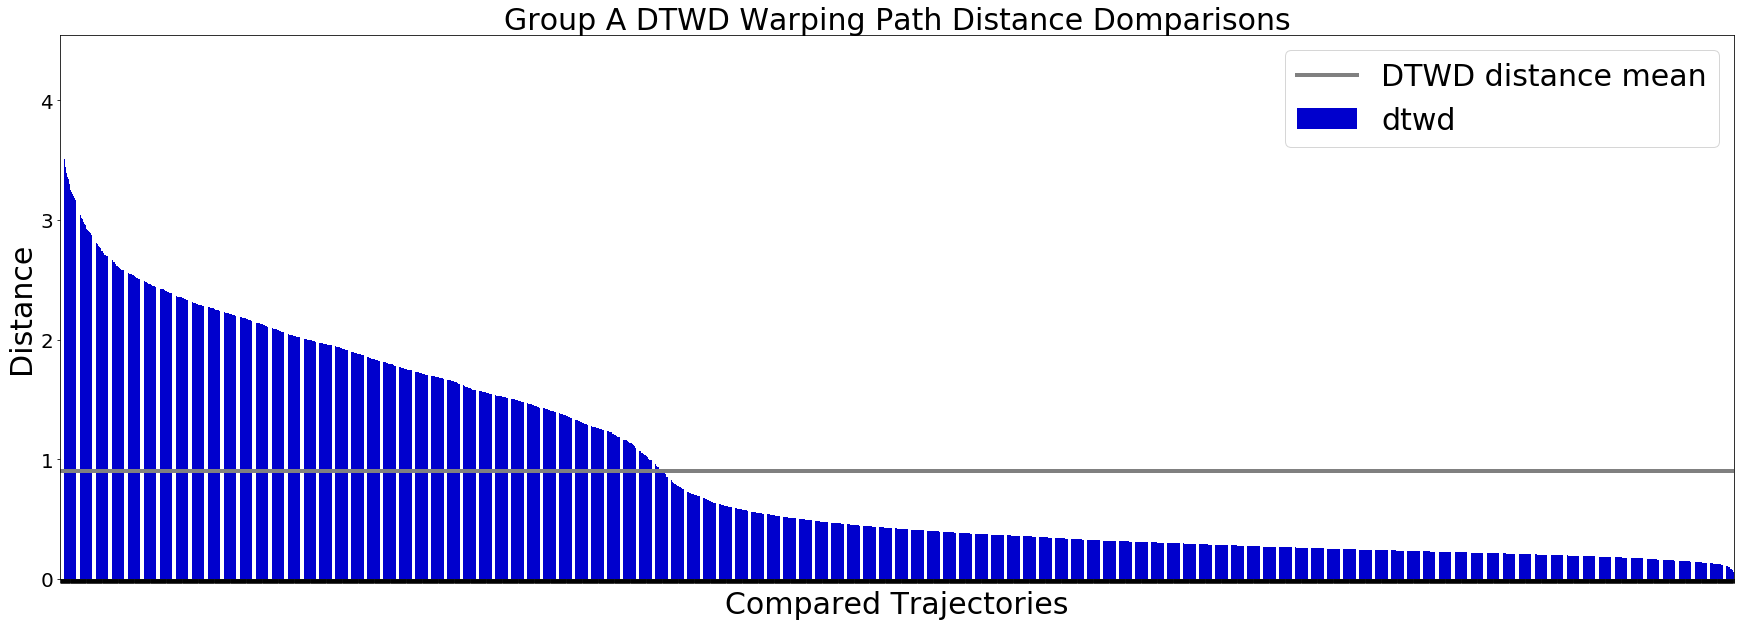

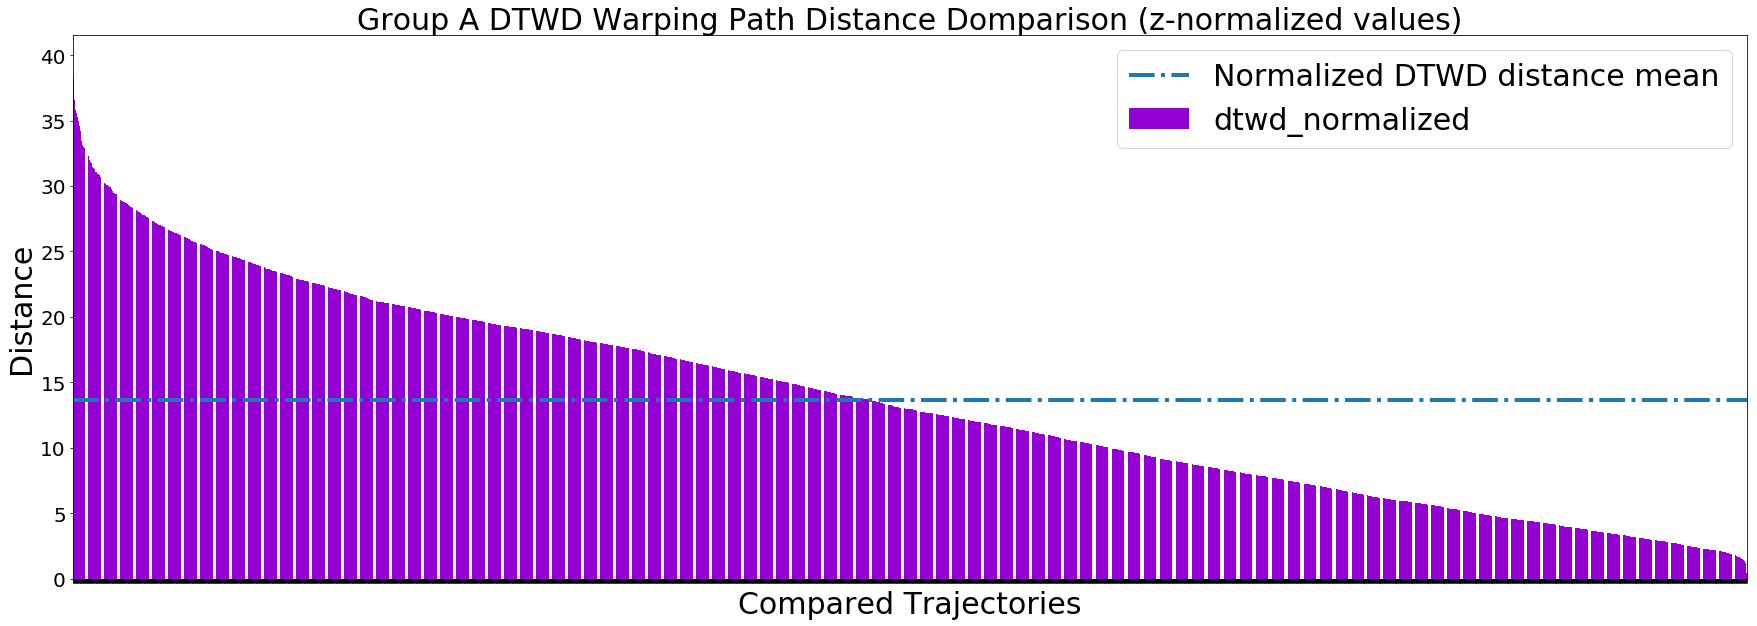

In [103]:
plot_dtwd_dtwi_occurrencies(group_A_DTW_trajectory_comparisons_among_users, title="Group A DTWD Warping Path Distance Domparisons", dtwd=True, dtwi=False, dtwd_normalized=False,dtwi_normalized=False)
plot_dtwd_dtwi_occurrencies(group_A_DTW_trajectory_comparisons_among_users, title="Group A DTWD Warping Path Distance Domparison (z-normalized values)", dtwd=False, dtwi=False, dtwd_normalized=True,dtwi_normalized=False)